In [37]:
import pandas as pd
import numpy as np

recalc_everything = True

import altair as alt
print(alt.__version__)
alt.data_transformers.disable_max_rows()
alt.renderers.enable('default')
import altair_saver
import selenium
print(selenium.__version__)

save_figures = True
import vl_convert as vlc
def save_chart(chart_to_save, filename):
    svg_str = vlc.vegalite_to_svg(chart_to_save.to_json())
    with open(filename, "wt") as f:
        f.write(svg_str)

import termcolor
import io
import os

mainstandirname = '../../../Taiwan_Backup/Monkeypox_2022'
os.makedirs(mainstandirname, exist_ok=True)

from IPython.display import Markdown as md

%matplotlib inline
%config matplotlib_inline.matplotlib_formats = 'retina'
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt

# chinese font
from matplotlib import font_manager
fontP = font_manager.FontProperties(fname="./NotoSerifTC-Regular.otf")
fontP.set_size(10)

import pathlib
import platform

import cmdstanpy as cmdstan
import arviz as az
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='arviz')
standistribdir = '../../../../CmdStan'
cmdstan.set_cmdstan_path(standistribdir[3:] if platform.system()=='Darwin' else standistribdir)

func_dict = {"q2.5": lambda x: np.percentile(x, 2.5),
             "q25": lambda x: np.percentile(x, 25),
             "median": lambda x: np.percentile(x, 50),
             "q75": lambda x: np.percentile(x, 75),
             "q97.5": lambda x: np.percentile(x, 97.5)}

def get_stats(cmdstan_data, varnames, round_to_=5):
    # include mean and hdi
    stats = az.summary(cmdstan_data, round_to=round_to_, var_names=varnames, hdi_prob=0.95).loc[:, ['mean','hdi_2.5%','hdi_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hdi_2.5%':'hdi2.5', 'hdi_97.5%':'hdi97.5'})
    stats = az.summary(cmdstan_data, round_to=round_to_, var_names=varnames, hdi_prob=0.50).loc[:, ['hdi_25%','hdi_75%']].reset_index().rename(columns={'index':'var', 'hdi_25%':'hdi25', 'hdi_75%':'hdi75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, round_to=round_to_, var_names=varnames, stat_funcs=func_dict, extend=False).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else int(x)+1 for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hdi2.5','hdi25','hdi75','hdi97.5','q2.5','q25','median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

def get_stats_2d(cmdstan_data, varnames, rounding=2):
    # include mean and hpd
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.95, round_to=rounding).loc[:, ['mean','hdi_2.5%','hdi_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hdi_2.5%':'hdi2.5', 'hdi_97.5%':'hdi97.5'})
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.50, round_to=rounding).loc[:, ['hdi_25%','hdi_75%']].reset_index().rename(columns={'index':'var', 'hdi_25%':'hdi25', 'hdi_75%':'hdi75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, var_names=varnames, stat_funcs=func_dict, extend=False, round_to=rounding).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else x for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hdi2.5','hdi25','hdi75','hdi97.5','q2.5','q25',
                        'median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

clrs_ = ["#00a1d5", "#fee391", "#d8daeb", "#bababa", "k"] # via https://nanx.me/ggsci/index.html #blue = #74add1 #yellow = #fee391

num_warmup = 1000
num_iterations = 1250
num_chains = 4

import rpy2.rinterface
%load_ext rpy2.ipython
rpy2.robjects.r['options'](warn=-1)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='arviz')
warnings.filterwarnings("ignore", category=RuntimeWarning, module='arviz')
from pytz_deprecation_shim import PytzUsageWarning
warnings.filterwarnings('ignore', category=PytzUsageWarning)

import pyreadr

5.1.1
4.12.0
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [38]:
remote_userID = 'XXX'
remote_userPSW = 'XXX'
remote_IP = 'XXX'
remote_ip = remote_IP

num_warmup = 1000
num_iterations = 1250
num_chains = 4

# Data

In [39]:
date_upper = pd.to_datetime("2023-07-05", format="%Y-%m-%d")
date_lower = date_upper - pd.DateOffset(days = 45)
date_lower

Timestamp('2023-05-21 00:00:00')

In [40]:
mindate = pd.to_datetime("2023-05-15", format="%Y-%m-%d")
mindate_to_show = pd.to_datetime("2023-05-01", format="%Y-%m-%d")
maxdate_to_show = pd.to_datetime("2023-07-20", format="%Y-%m-%d")
cutoff_date = pd.to_datetime("2023-07-15", format="%Y-%m-%d")
truncation_date = pd.to_datetime("2023-08-15", format="%Y-%m-%d")

## A. Main epicurve

In [41]:
df_cases = pd.read_csv('../../data/epicurve_figure_1.csv')
df_cases['Date'] = pd.to_datetime(df_cases['Date'], format="%Y-%m-%d")
df_cases

,Date,Onset,Reported,Diagnosis
0,2023-05-15,0,0,0
1,2023-05-16,0,2,0
2,2023-05-17,0,0,0
3,2023-05-18,0,0,0
4,2023-05-19,0,0,0
...,...,...,...,...
62,2023-07-16,12,0,0
63,2023-07-17,16,0,0
64,2023-07-18,7,0,0
65,2023-07-19,15,0,0


In [42]:
clrs_ = ["#00a1d5", "#fee391", "#d8daeb", "#bababa", "k"]
colors = ['#4575b4', '#fdae61']
ymx = 23

base = alt.Chart(df_cases).encode(
    alt.X('Date', axis=alt.Axis(title="Date of symptom onset (month/day in 2023)", format = ("%m/%d")), 
          scale=alt.Scale(domain=[mindate, maxdate_to_show]))
)

bar_cases_obs = base.mark_area(interpolate='step-before', color=clrs_[0], binSpacing=0, width=5.25, clip=True).encode(
    alt.Y('Onset:Q', scale=alt.Scale(domain=[0, ymx]), sort=['local', 'imported'][::-1])
).configure_range(
        category=alt.RangeScheme(clrs_)
).resolve_scale(y = 'independent').properties(width=400, height=300).configure_axis(grid=False)

bar_cases_obs

alt.Chart(...)

## B. Loading linelist data from Hong Kong

In [43]:
df_linelist_hk = pd.read_excel(os.path.join("../../data", "20230823-HongKong-linelist.xlsx")).drop(['Source', 'Remarks'], axis=1)
df_linelist_hk

,CaseNo,Age,Sex,Comorbidities,Onset,Rash,Diagnosis,Confirmation,Reporting,Exposure
0,1,40,M,N,2023-01-31,2023-02-01,2023-02-01,NaT,2023-02-04,Japan
1,2,34,M,N,2023-04-12,2023-04-12,2023-04-19,NaT,2023-04-20,HK
2,3,25,M,N,2023-04-12,2023-04-12,2023-04-20,2023-04-21,2023-04-21,Korea/Taiwan
3,4,59,M,Y,2023-04-25,2023-04-25,2023-04-27,2023-04-28,2023-04-29,China
4,5,34,M,N,2023-04-30,2023-04-30,2023-04-30,NaT,2023-05-01,Taiwan/HK
5,6,44,M,Y,2023-05-07,NaT,2023-05-09,2023-05-10,2023-05-11,HK
6,7,54,M,Y,2023-06-15,2023-06-15,2023-06-19,2023-06-20,2023-06-21,HK
7,8,48,M,Y,2023-07-02,NaT,2023-07-05,2023-07-06,2023-07-07,HK
8,9,40,M,NaN,2023-07-10,NaT,2023-07-12,2023-07-13,2023-07-13,HK
9,10,20,M,N,2023-07-08,2023-07-10,2023-07-16,2023-07-18,2023-07-18,Japan


## C. Identifying some variable for the simulations

In [44]:
TJul1_ = (pd.to_datetime('2023-07-01')-mindate).days + 1
TAug1_ = (pd.to_datetime('2023-08-01')-mindate).days + 1
TSep1_ = (pd.to_datetime('2023-09-01')-mindate).days + 1

# <font color="green">2. Analysis</font>

## <font color="orange">2a. Identifying the reporting delay from HK data</font>

In [45]:
truncation_date_hk = pd.to_datetime('2023-08-23')

### By reporting date

['../../../Taiwan_Backup/Monkeypox_2022/20230823_reporting_delay_HK_gengamma/trace-2.csv', '../../../Taiwan_Backup/Monkeypox_2022/20230823_reporting_delay_HK_gengamma/trace-3.csv', '../../../Taiwan_Backup/Monkeypox_2022/20230823_reporting_delay_HK_gengamma/trace-4.csv', '../../../Taiwan_Backup/Monkeypox_2022/20230823_reporting_delay_HK_gengamma/trace-1.csv']


,Parameter,Mean (95% CI)
0,"Mean delay, days","5.97 (5.05, 7.00)"
1,"SD, days","2.72 (2.12, 3.66)"
2,a,"1.32 (0.25, 4.70)"
3,sigma,"0.42 (0.29, 0.58)"
4,mu,"1.91 (1.70, 2.13)"
5,q,"1.07 (0.46, 2.01)"
6,loga,"-0.01 (-1.39, 1.55)"
7,logsigma,"-0.89 (-1.25, -0.54)"


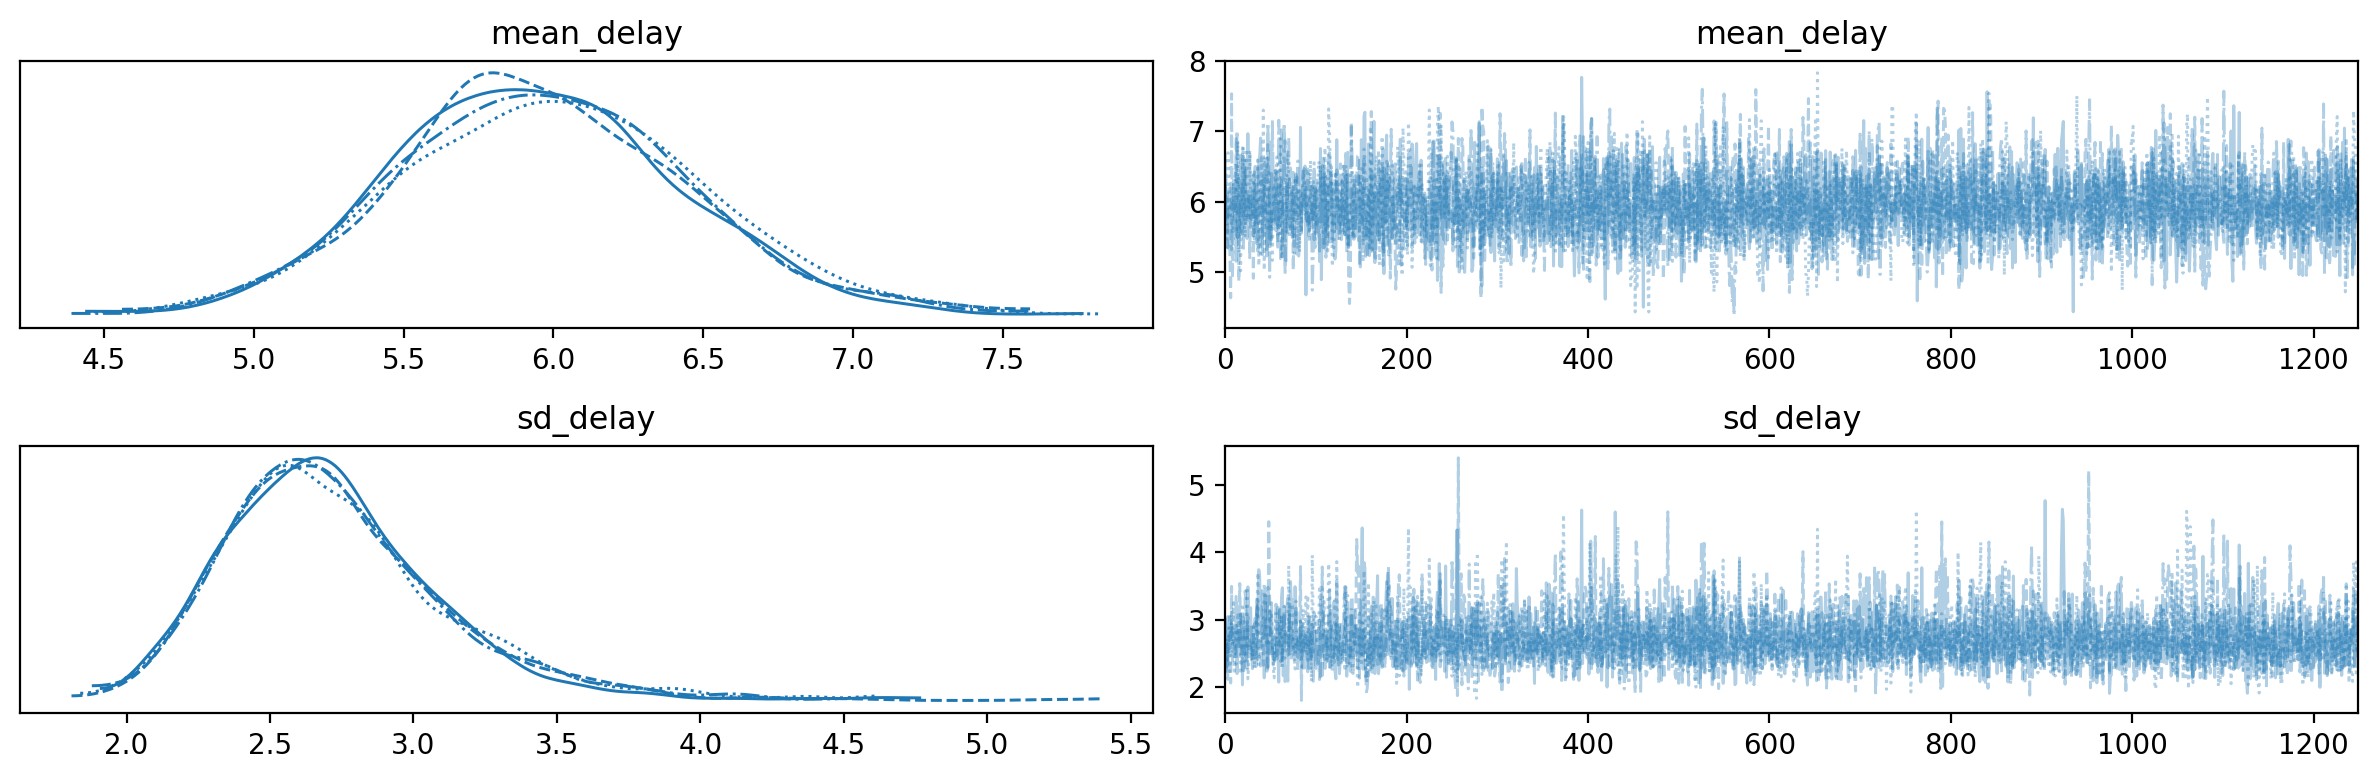

In [46]:
basename = truncation_date_hk.strftime("%Y%m%d")+f'_reporting_delay_HK_gengamma'
standirname = os.path.join(mainstandirname, basename)

paths = [str(x) for x in list(pathlib.Path(standirname).glob("trace*.csv"))]
print(paths)
fit_rep_delay = cmdstan.from_csv(paths)

idata_rep_delay = az.from_cmdstanpy(posterior=fit_rep_delay)

mod_delay_summary_output = get_stats(idata_rep_delay.posterior, ['mean_delay', 'sd_delay', 'a', 'sigma', 'mu', 'q', 'loga', 'logsigma'])
mod_delay_summary_output['var'] = mod_delay_summary_output['var'].astype('string')
for col in mod_delay_summary_output.columns[2:]:
    mod_delay_summary_output[col] = mod_delay_summary_output[col].astype('float')
mod_delay_summary_output['Mean (95% CI)'] = ["%.2f (%.2f, %.2f)" % (x, y, z) for (x,y,z) in zip(mod_delay_summary_output['mean'], mod_delay_summary_output['q2.5'], mod_delay_summary_output['q97.5'])]
mod_delay_summary_output['Parameter'] = ['Mean delay, days','SD, days','a', 'sigma', 'mu', 'q', 'loga', 'logsigma'] 

az.plot_trace(idata_rep_delay, var_names=('mean_delay', 'sd_delay')); plt.tight_layout()
mod_delay_summary = az.summary(idata_rep_delay, var_names=['mean_delay', 'sd_delay'], hdi_prob=0.95)

display(mod_delay_summary_output.loc[:, ['Parameter', 'Mean (95% CI)']])

In [47]:
stats_summary_rep_delay = az.summary(idata_rep_delay, ['mu', 'loga', 'logsigma'])
stats_summary_rep_delay

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,1.911,0.109,1.717,2.122,0.001,0.001,6378.0,3739.0,1.0
loga,-0.010,0.737,-1.402,1.391,0.010,0.009,5914.0,3920.0,1.0
logsigma,-0.887,0.181,-1.230,-0.556,0.003,0.002,5190.0,4025.0,1.0


### By diagnosis date

['../../../Taiwan_Backup/Monkeypox_2022/20230823_reporting_delay_HK_gengamma-diangosis/trace-2.csv', '../../../Taiwan_Backup/Monkeypox_2022/20230823_reporting_delay_HK_gengamma-diangosis/trace-3.csv', '../../../Taiwan_Backup/Monkeypox_2022/20230823_reporting_delay_HK_gengamma-diangosis/trace-4.csv', '../../../Taiwan_Backup/Monkeypox_2022/20230823_reporting_delay_HK_gengamma-diangosis/trace-1.csv']


,Parameter,Mean (95% CI)
0,"Mean delay, days","3.44 (2.65, 4.44)"
1,"SD, days","2.47 (1.81, 3.84)"
2,a,"1.27 (0.18, 5.21)"
3,sigma,"0.68 (0.42, 0.98)"
4,mu,"1.36 (0.97, 1.75)"
5,q,"1.17 (0.44, 2.33)"
6,loga,"-0.14 (-1.69, 1.65)"
7,logsigma,"-0.41 (-0.86, -0.02)"


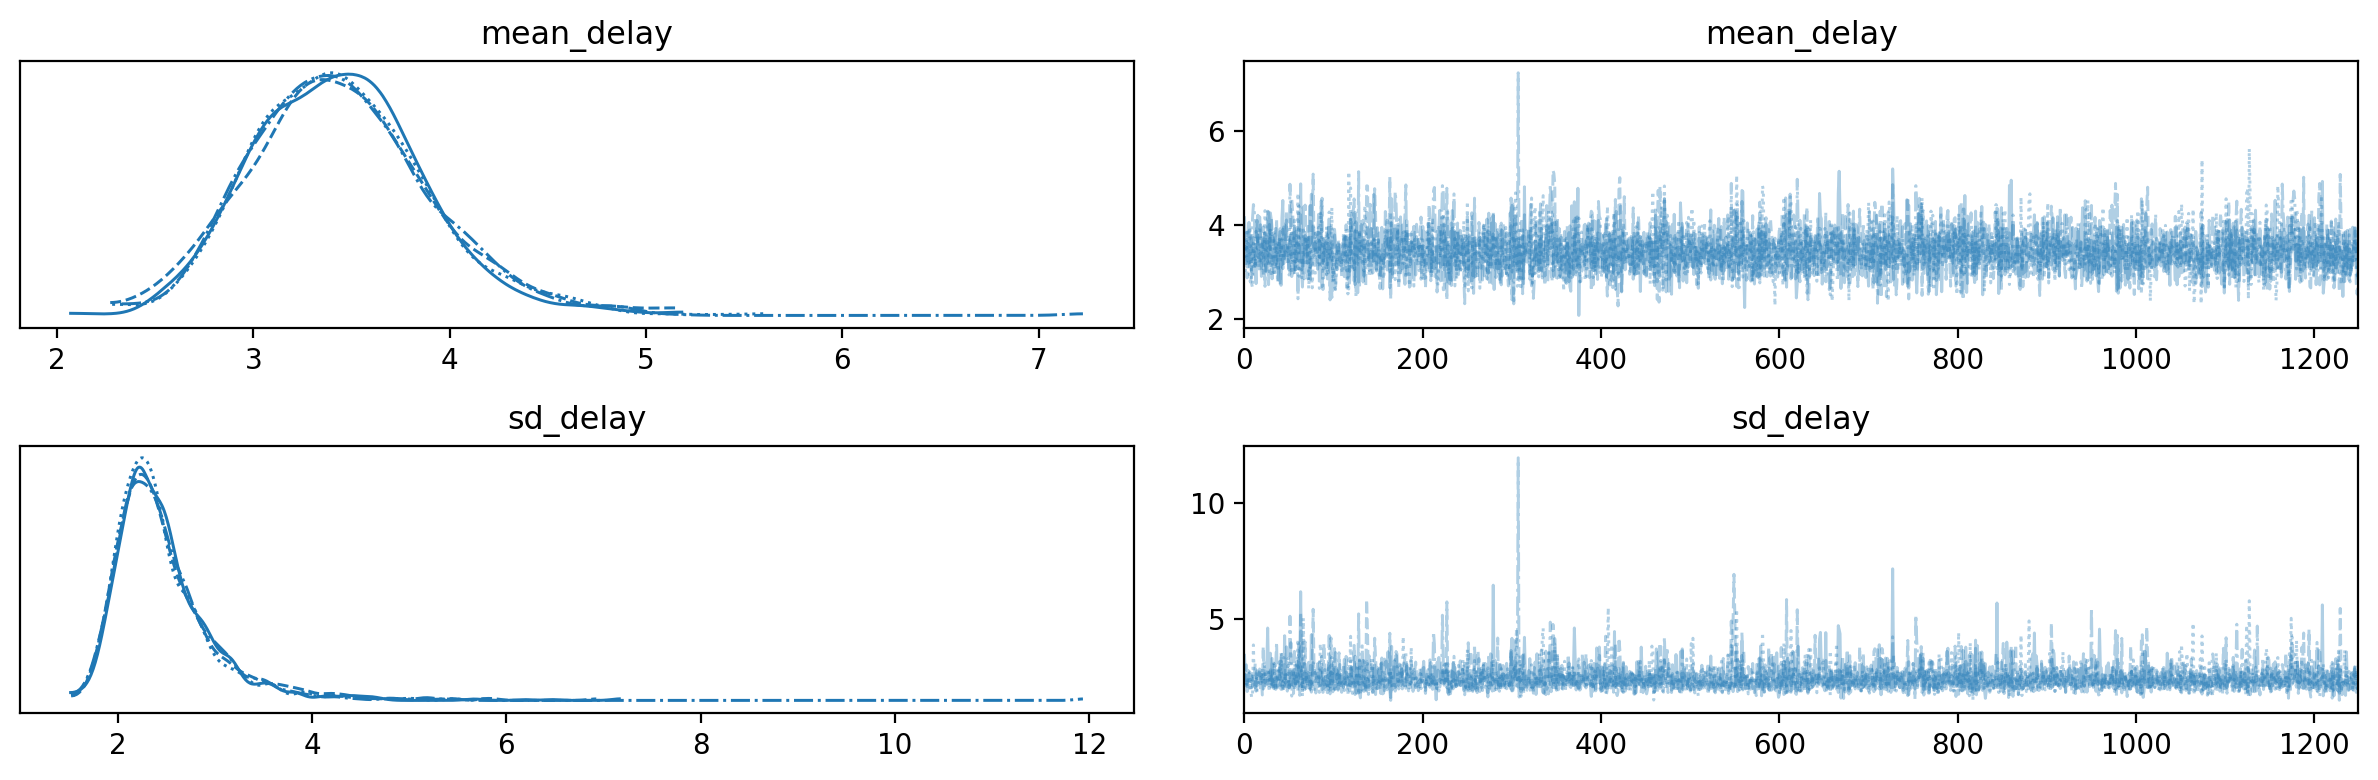

In [48]:
basename = truncation_date_hk.strftime("%Y%m%d")+f'_reporting_delay_HK_gengamma-diangosis'
standirname = os.path.join(mainstandirname, basename)

paths = [str(x) for x in list(pathlib.Path(standirname).glob("trace*.csv"))]
print(paths)
fit_rep_delay_diagnosis = cmdstan.from_csv(paths)

idata_rep_delay_diagnosis = az.from_cmdstanpy(posterior=fit_rep_delay_diagnosis)

mod_delay_diagnosis_summary_output = get_stats(idata_rep_delay_diagnosis.posterior, ['mean_delay', 'sd_delay', 'a', 'sigma', 'mu', 'q', 'loga', 'logsigma'])
mod_delay_diagnosis_summary_output['var'] = mod_delay_diagnosis_summary_output['var'].astype('string')
for col in mod_delay_diagnosis_summary_output.columns[2:]:
    mod_delay_diagnosis_summary_output[col] = mod_delay_diagnosis_summary_output[col].astype('float')
mod_delay_diagnosis_summary_output['Mean (95% CI)'] = ["%.2f (%.2f, %.2f)" % (x, y, z) for (x,y,z) in zip(mod_delay_diagnosis_summary_output['mean'], mod_delay_diagnosis_summary_output['q2.5'], mod_delay_diagnosis_summary_output['q97.5'])]
mod_delay_diagnosis_summary_output['Parameter'] = ['Mean delay, days','SD, days','a', 'sigma', 'mu', 'q', 'loga', 'logsigma'] 

az.plot_trace(idata_rep_delay_diagnosis, var_names=('mean_delay', 'sd_delay')); plt.tight_layout()
mod_delay_diagnosis_summary = az.summary(idata_rep_delay_diagnosis, var_names=['mean_delay', 'sd_delay'], hdi_prob=0.95)

display(mod_delay_diagnosis_summary_output.loc[:, ['Parameter', 'Mean (95% CI)']])

In [49]:
stats_summary_rep_delay_diagnosis = az.summary(idata_rep_delay_diagnosis, ['mu', 'loga', 'logsigma'])
stats_summary_rep_delay_diagnosis

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,1.357,0.195,0.990,1.729,0.003,0.002,4979.0,3487.0,1.0
loga,-0.137,0.838,-1.701,1.456,0.012,0.011,4705.0,3503.0,1.0
logsigma,-0.410,0.207,-0.778,-0.001,0.003,0.002,4755.0,3145.0,1.0


## <font color="orange">2b. Estimating the R0 in Mainland China</font>

In [50]:
stan_code_exp_growth = """functions {
    real gengamma_cdf(real x, real q, real mu, real sigma) {
        real logx = log(x),
            z = (logx - mu) / sigma,
            a = inv_square(q),
            value = gamma_cdf(a * exp(q * z) | a, 1);

        return value;
    }

    /* discretized version */
    vector dgengamma(real q, real mu, real sigma, int D) {
        vector[D] res;
        for (k in 1:D)
            res[k] = gengamma_cdf(k - 0.5 | q, mu, sigma);

        if (D > 1)
            return append_row(append_row(res[1], tail(res, D-1) - head(res, D-1)), 1.0 - res[D]);
        else 
            return to_vector({res[1], 1 - res[1]});
    }

    vector dgamma(real param1, real param2, int K) {
        vector[K] res;
        for (k in 1:K)
            res[k] = gamma_cdf(k - 0.5 | param1, param2);

        return append_row(res[1], tail(res, K-1) - head(res, K-1));
    }
}

data {
    int<lower = 1> Tlower, Tupper; // the cutoffday for the estimation of the exponential growth 
    array[Tupper] int<lower = 0> cases_onset; // number of cases by date of symptom onset starting to be recorded till the day Tupper

    int<lower = Tupper> T; // total number of days for which we have the data on number of cases by date of notification (their symptom onset date is missed)
    array[T] int<lower = 0> cases_reported, cases_diagnosis;

    int<lower = Tupper> Tpred;
    int<upper = Tpred> TJul1, TAug1, TSep1;

    // reporting delay described by the generalized gamma distribution
    real loga, logsigma, mu;

    // delay b/w onset and diagnosis described by the generalized gamma distribution
    real loga_diagnosis, logsigma_diagnosis, mu_diagnosis;

    // generation time (scale and shape of the Gamma distribution estimated in Guzetta et al. 2022)
    real<lower = 0> genalpha, geninvbeta;
}

transformed data {
    // reporting delay
    real a = exp(loga), q = inv_sqrt(a), sigma = exp(logsigma);

    // delay b/w onset and diagnosis
    real a_diagnosis = exp(loga_diagnosis), q_diagnosis = inv_sqrt(a_diagnosis), sigma_diagnosis = exp(logsigma_diagnosis);

    // generation time
    real genmean = genalpha * geninvbeta,
        gensigma = sqrt(genalpha) * geninvbeta;

    vector[Tupper] gent = dgamma(genalpha, 1.0 / geninvbeta, Tupper),
          gent_rev = reverse(gent);

    // backprojecting from the reporting date
    array[T] int cases_onset_backprj = rep_array(0, T);
    for (t in 1:T) 
        if (cases_reported[t] > 0) {
            vector[t+1] probs_for_backprojection = dgengamma(q, mu, sigma, t);
            array[t+1] int counts_backprj = multinomial_rng(probs_for_backprojection, cases_reported[t]);
            for (i in 1:t) 
                cases_onset_backprj[t-i+1] += counts_backprj[i];
        }

    // backprojecting from the diagnosis date
    for (t in 1:T) 
        if (cases_diagnosis[t] > 0) {
            vector[t+1] probs_for_backprojection = dgengamma(q_diagnosis, mu_diagnosis, sigma_diagnosis, t);
            array[t+1] int counts_backprj = multinomial_rng(probs_for_backprojection, cases_diagnosis[t]);
            for (i in 1:t) 
                cases_onset_backprj[t-i+1] += counts_backprj[i];
        }


    array[Tupper] int cases;
    for (t in 1:Tupper) 
        cases[t] = cases_onset[t] + cases_onset_backprj[t];

    real jitter = 1e-9;
}

parameters {
    // exponential growth rate
    real logr;
    // initial incidence
    real<lower = 0> i0;
    // process error
    real<lower = 0> phi;
}

transformed parameters {
    real r = exp(logr);
}

model {
    logr ~ std_normal();
    i0 ~ normal(5, 10);
    phi ~ gamma(1, 1);

    for (t in Tlower:Tupper)
        if (cases[t] > 0)
            target += neg_binomial_2_lupmf(cases[t] | i0 * exp(r * t) + jitter, phi); 
}

generated quantities {
    // basic reproduction number
    real R0 = exp(r * genmean - 0.5 * square(r) * square(gensigma));

    // doubling time
    real doubling_time = log(2) / r; 

    array[Tpred] int cases_prj = rep_array(0, Tpred);
    for (t in 1:Tpred)
        cases_prj[t] = (t > Tupper) ? neg_binomial_2_rng(i0 * exp(r * t), phi) : cases[t];

    int casesJul = sum(cases_prj[TJul1:TAug1-1]), 
        casesAug = sum(cases_prj[TAug1:TSep1-1]);

    array[Tpred] int cases_reported_prj = rep_array(0, Tpred);
    for (t in 1:Tpred) 
        if (cases_prj[t] > 0) {
            vector[Tpred-t+2] probs_for_prj = dgengamma(q, mu, sigma, Tpred-t+1);
            array[Tpred-t+2] int counts = multinomial_rng(probs_for_prj, cases_prj[t]);
            for (s in 1:Tpred-t+1)
                cases_reported_prj[t+s-1] += counts[s];
        }

    int reportedJul = sum(cases_reported_prj[TJul1:TAug1-1]), 
        reportedAug = sum(cases_reported_prj[TAug1:TSep1-1]);
}"""

In [35]:
def sim(Tlower_, Tupper_):
    basename = truncation_date_hk.strftime("%Y%m%d")+f'_exp_growth_China_expwindow_{Tlower_}-{Tupper_}'
    standirname = os.path.join(mainstandirname, basename)
    !rm {standirname}/*
    os.makedirs(standirname, exist_ok=True)
    stanscriptdir = '../Dropbox/'+standirname[9:]

    Df_ = df_cases
    
    stan_data = dict({
        'Tlower': Tlower_,
        'Tupper': Tupper_,
        'Tpred': TSep1_+1,
        'TJul1': TJul1_,
        'TAug1': TAug1_,
        'TSep1': TSep1_,
        'cases_onset': Df_['Onset'].astype('int64').values[:Tupper_],
        'T': Df_.shape[0],
        'cases_reported': Df_['Reported'].astype('int64').values,
        'loga': stats_summary_rep_delay.loc['loga']['mean'],
        'logsigma': stats_summary_rep_delay.loc['logsigma']['mean'],
        'mu': stats_summary_rep_delay.loc['mu']['mean'],
        'cases_diagnosis': Df_['Diagnosis'].astype('int64').values,
        'loga_diagnosis': stats_summary_rep_delay_diagnosis.loc['loga']['mean'],
        'logsigma_diagnosis': stats_summary_rep_delay_diagnosis.loc['logsigma']['mean'],
        'mu_diagnosis': stats_summary_rep_delay_diagnosis.loc['mu']['mean'],
        'genalpha': 4.85,
        'geninvbeta': 2.57
    })
    stan_data_file = os.path.join(standirname, 'Data.json')
    cmdstan.write_stan_json(stan_data_file, stan_data)

    stan_inits = dict({
        'r': 0.1,
        'phi': 1.0
    })
    stan_init_file = os.path.join(standirname, 'Inits.json')
    cmdstan.write_stan_json(stan_init_file, stan_inits)

    stan_code_file = os.path.join(standirname, f'fit_exp_growth.stan')
    with open(stan_code_file, "w+") as f:
        f.write(stan_code_exp_growth)
        f.close()
    
    model = cmdstan.CmdStanModel(stan_file=stan_code_file, cpp_options={'STAN_THREADS': 'TRUE'}, compile='force')
    fit = model.sample(data=stan_data_file, seed = 1, iter_warmup=num_warmup, iter_sampling=1, inits=stan_init_file, parallel_chains=10,
                       show_console=False, show_progress=False, chains = 4000)
    fit.save_csvfiles(dir=standirname)

In [ ]:
%%time
for date_lower_ in pd.date_range(pd.to_datetime('2023-05-16'), pd.to_datetime('2023-05-26')):
    for date_upper_ in pd.date_range(pd.to_datetime('2023-06-30'), pd.to_datetime('2023-07-10')):
        Tlower_ = (date_lower_-mindate).days + 1
        Tupper_ = (date_upper_-mindate).days + 1
        print([date_lower_, date_upper_], [Tlower_, Tupper_])
        sim(Tlower_, Tupper_)

In [17]:
basename = truncation_date_hk.strftime("%Y%m%d")+f'_exp_growth_China_expwindow_{Tlower_}-{Tupper_}'
standirname = os.path.join(mainstandirname, basename)
idata_chn = az.from_cmdstanpy(cmdstan.from_csv(path=standirname))
df_stats_chn = get_stats(idata_chn.posterior, ['r', 'i0', 'phi', 'R0', 'doubling_time']) 
df_stats_chn

arviz - WARNING - Shape validation failed: input_shape: (4000, 1), minimum_shape: (chains=1, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (4000, 1), minimum_shape: (chains=1, draws=4)


,var,time,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat
0,r,NA,0.03903,0.02824,0.03505,0.04305,0.05150,0.02762,0.03494,0.03893,0.04295,0.05114,NaN,NaN,NaN
1,i0,NA,2.21338,1.30858,1.77887,2.44007,3.29182,1.34340,1.84828,2.16218,2.51660,3.40004,NaN,NaN,NaN
2,phi,NA,6.90059,3.61805,4.97446,7.51604,10.78030,3.77656,5.46120,6.72218,8.11227,11.19994,NaN,NaN,NaN
3,R0,NA,1.58998,1.38080,1.51552,1.65790,1.79450,1.39377,1.51577,1.58566,1.65827,1.81396,NaN,NaN,NaN
4,doubling_time,NA,18.19458,12.99780,15.56700,19.10890,23.84120,13.55470,16.13940,17.80375,19.83982,25.09879,NaN,NaN,NaN


In [ ]:
%%time
Df_stats = None
fldrs = !ls {mainstandirname} | grep _expwindow_
for fldr in fldrs:
    print(fldr)
    standirname = os.path.join(mainstandirname, fldr)
    Tlower_ = int(fldr.split("_expwindow_")[-1].split("-")[0])
    Tupper_ = int(fldr.split("_expwindow_")[-1].split("-")[-1])
    idata_chn = az.from_cmdstanpy(cmdstan.from_csv(path=standirname))
    df_stats_ = get_stats(idata_chn.posterior, ['R0', 'doubling_time', 'reportedJul', 'reportedAug']) 
    df_stats_['Tlower'] = Tlower_
    df_stats_['Tupper'] = Tupper_
    df_stats_ = df_stats_.drop(['ess_bulk', 'ess_tail', 'r_hat'], axis=1)
    Df_stats = df_stats_ if Df_stats is None else pd.concat([Df_stats, df_stats_], ignore_index=True)

In [53]:
Df_stats

,var,time,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,Tlower,Tupper
0,R0,NA,1.70579,1.38991,1.58157,1.79227,2.02816,1.40229,1.59408,1.70000,1.80628,2.04911,10,47
1,doubling_time,NA,15.96106,10.39020,12.77050,16.42910,22.98160,11.07449,13.65940,15.33635,17.59040,24.62926,10,47
2,reportedJul,NA,837.45975,438.00000,614.00000,887.00000,1294.00000,480.00000,669.00000,802.00000,961.00000,1395.00000,10,47
3,reportedAug,NA,3791.62700,695.00000,1714.00000,3719.00000,8000.00000,1166.95000,2264.00000,3251.00000,4604.25000,9554.02500,10,47
4,R0,NA,1.71935,1.42528,1.59490,1.80274,2.03231,1.43502,1.60873,1.71168,1.82090,2.04502,10,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,reportedAug,NA,2742.88800,1175.00000,1804.00000,2875.00000,4644.00000,1374.00000,2063.00000,2577.00000,3239.25000,5119.27500,9,56
480,R0,NA,1.59638,1.40431,1.51570,1.64959,1.80406,1.40503,1.52651,1.59308,1.66196,1.80640,9,57
481,doubling_time,NA,17.97815,13.13640,15.75540,19.05500,23.30140,13.65768,16.06438,17.61530,19.49238,24.48206,9,57
482,reportedJul,NA,664.94200,506.00000,580.00000,694.00000,856.00000,514.00000,601.00000,655.00000,719.00000,876.02500,9,57


In [54]:
Df_stats.Tlower.drop_duplicates()

0      10
44     11
88     12
132     2
176     3
220     4
264     5
308     6
352     7
396     8
440     9
Name: Tlower, dtype: int64

In [69]:
Df_stats['date_lower'] = [mindate + pd.DateOffset(days = x - 1) for x in Df_stats['Tlower']]
Df_stats['date_upper'] = [mindate + pd.DateOffset(days = x - 1) for x in Df_stats['Tupper']]

In [70]:
Df_stats_table = Df_stats.loc[lambda d: d['var']=='R0', ['Tlower', 'Tupper', 'median']].pivot_table(values='median', index='Tlower', columns='Tupper')
Df_stats_table

Tupper,47,48,49,50,51,52,53,54,55,56,57
Tlower,,,,,,,,,,,
2,1.69234,1.70052,1.69334,1.71390,1.70338,1.68113,1.66610,1.67286,1.66034,1.63194,1.59308
3,1.69234,1.70052,1.69334,1.71390,1.70338,1.68113,1.66610,1.67286,1.66034,1.63194,1.59308
4,1.69234,1.70052,1.69334,1.71390,1.70338,1.68113,1.66610,1.67286,1.66034,1.63194,1.59308
5,1.69234,1.70052,1.69334,1.71390,1.70338,1.68113,1.66610,1.67286,1.66034,1.63194,1.59308
6,1.69234,1.70052,1.69334,1.71390,1.70338,1.68113,1.66610,1.67286,1.66034,1.63194,1.59308
7,1.69234,1.70052,1.69334,1.71390,1.70338,1.68113,1.66610,1.67286,1.66034,1.63194,1.59308
8,1.69234,1.70052,1.69334,1.71390,1.70338,1.68113,1.66610,1.67286,1.66034,1.63194,1.59308
9,1.69234,1.70052,1.69334,1.71390,1.70338,1.68113,1.66610,1.67286,1.66034,1.63194,1.59308
10,1.70000,1.71168,1.70512,1.72182,1.71176,1.68220,1.67252,1.67449,1.66270,1.63743,1.58876


In [71]:
Df_stats.date_lower.drop_duplicates()

0     2023-05-24
44    2023-05-25
88    2023-05-26
132   2023-05-16
176   2023-05-17
220   2023-05-18
264   2023-05-19
308   2023-05-20
352   2023-05-21
396   2023-05-22
440   2023-05-23
Name: date_lower, dtype: datetime64[ns]

In [72]:
Df_stats.date_upper.drop_duplicates()

0    2023-06-30
4    2023-07-01
8    2023-07-02
12   2023-07-03
16   2023-07-04
20   2023-07-05
24   2023-07-06
28   2023-07-07
32   2023-07-08
36   2023-07-09
40   2023-07-10
Name: date_upper, dtype: datetime64[ns]

### Estimates of Re

In [73]:
wd_ = 300; ht_ = 270
heatmap = alt.Chart(Df_stats.loc[lambda d: d['var']=='R0', ['date_lower', 'date_upper', 'median']]).mark_rect().encode(
    x=alt.X('yearmonthdate(date_lower)', title="Lower bound date", axis=alt.Axis(format='%m/%d', labelAngle=-90)),
    y=alt.Y('yearmonthdate(date_upper)', title="Upper bound date", axis=alt.Axis(format='%m/%d', labelAngle=0), scale=alt.Scale(reverse=True)),
    color=alt.Color('median:Q', scale=alt.Scale(scheme='greens', reverse=False), title="median")
)

Df_stats_ = Df_stats.loc[lambda d: d['var']=='R0', ['date_lower', 'date_upper', 'median']]
print("Min median:", Df_stats_['median'].min())
print("Max median:", Df_stats_['median'].max())

chart = alt.layer(heatmap).properties(width=wd_, height=ht_)
save_chart(chart, f'../../figures/sensitivity-Re-median.svg')
chart

Min median: 1.5775
Max median: 1.72182


alt.LayerChart(...)

In [74]:
heatmap = alt.Chart(Df_stats.loc[lambda d: d['var']=='R0', ['date_lower', 'date_upper', 'q2.5']].rename(columns={'q2.5':'lower'})).mark_rect().encode(
    x=alt.X('yearmonthdate(date_lower)', title="Lower bound date", axis=alt.Axis(format='%m/%d', labelAngle=-90)),
    y=alt.Y('yearmonthdate(date_upper)', title="Upper bound date", axis=alt.Axis(format='%m/%d', labelAngle=0), scale=alt.Scale(reverse=True)),
    color=alt.Color('lower:Q', scale=alt.Scale(scheme='greens', reverse=False), title="lower") #lighttealblue
)

Df_stats_ = Df_stats.loc[lambda d: d['var']=='R0', ['date_lower', 'date_upper', 'q2.5']]
print("Min lower:", Df_stats_['q2.5'].min())
print("Max lower:", Df_stats_['q2.5'].max())

chart = alt.layer(heatmap).properties(width=wd_, height=ht_)
save_chart(chart, f'../../figures/sensitivity-Re-lower.svg')
chart

Min lower: 1.38181
Max lower: 1.47351


alt.LayerChart(...)

In [75]:
heatmap = alt.Chart(Df_stats.loc[lambda d: d['var']=='R0', ['date_lower', 'date_upper', 'q97.5']].rename(columns={'q97.5':'upper'})).mark_rect().encode(
    x=alt.X('yearmonthdate(date_lower)', title="Lower bound date", axis=alt.Axis(format='%m/%d', labelAngle=-90)),
    y=alt.Y('yearmonthdate(date_upper)', title="Upper bound date", axis=alt.Axis(format='%m/%d', labelAngle=0), scale=alt.Scale(reverse=True)),
    color=alt.Color('upper:Q', scale=alt.Scale(scheme='greens', reverse=False), title="upper") #tealblues
)

Df_stats_ = Df_stats.loc[lambda d: d['var']=='R0', ['date_lower', 'date_upper', 'q97.5']]
print("Min upper:", Df_stats_['q97.5'].min())
print("Max upper:", Df_stats_['q97.5'].max())

chart = alt.layer(heatmap).properties(width=wd_, height=ht_)
save_chart(chart, f'../../figures/sensitivity-Re-upper.svg')
chart

Min upper: 1.80571
Max upper: 2.04911


alt.LayerChart(...)

### Reported cases in July

In [76]:
heatmap = alt.Chart(Df_stats.loc[lambda d: d['var']=='reportedJul', ['date_lower', 'date_upper', 'median']]).mark_rect().encode(
    x=alt.X('yearmonthdate(date_lower)', title="Lower bound date", axis=alt.Axis(format='%m/%d', labelAngle=-90)),
    y=alt.Y('yearmonthdate(date_upper)', title="Upper bound date", axis=alt.Axis(format='%m/%d', labelAngle=0), scale=alt.Scale(reverse=True)),
    color=alt.Color('median:Q', scale=alt.Scale(scheme='lighttealblue', reverse=False), title="median")
)

Df_stats_ = Df_stats.loc[lambda d: d['var']=='reportedJul', ['date_lower', 'date_upper', 'median']]
print("Min median:", Df_stats_['median'].min())
print("Max median:", Df_stats_['median'].max())

chart = alt.layer(heatmap).properties(width=wd_, height=ht_)
save_chart(chart, f'../../figures/sensitivity-reportedJul-median.svg')
chart

Min median: 650.0
Max median: 841.0


alt.LayerChart(...)

In [77]:
heatmap = alt.Chart(Df_stats.loc[lambda d: d['var']=='reportedJul', ['date_lower', 'date_upper', 'q2.5']].rename(columns={'q2.5':'lower'})).mark_rect().encode(
    x=alt.X('yearmonthdate(date_lower)', title="Lower bound date", axis=alt.Axis(format='%m/%d', labelAngle=-90)),
    y=alt.Y('yearmonthdate(date_upper)', title="Upper bound date", axis=alt.Axis(format='%m/%d', labelAngle=0), scale=alt.Scale(reverse=True)),
    color=alt.Color('lower:Q', scale=alt.Scale(scheme='lighttealblue', reverse=False), title="lower") #lighttealblue
)

Df_stats_ = Df_stats.loc[lambda d: d['var']=='reportedJul', ['date_lower', 'date_upper', 'q2.5']]
print("Min lower:", Df_stats_['q2.5'].min())
print("Max lower:", Df_stats_['q2.5'].max())

chart = alt.layer(heatmap).properties(width=wd_, height=ht_)
save_chart(chart, f'../../figures/sensitivity-reportedJul-lower.svg')
chart

Min lower: 476.0
Max lower: 569.975


alt.LayerChart(...)

In [78]:
heatmap = alt.Chart(Df_stats.loc[lambda d: d['var']=='reportedJul', ['date_lower', 'date_upper', 'q97.5']].rename(columns={'q97.5':'upper'})).mark_rect().encode(
    x=alt.X('yearmonthdate(date_lower)', title="Lower bound date", axis=alt.Axis(format='%m/%d', labelAngle=-90)),
    y=alt.Y('yearmonthdate(date_upper)', title="Upper bound date", axis=alt.Axis(format='%m/%d', labelAngle=0), scale=alt.Scale(reverse=True)),
    color=alt.Color('upper:Q', scale=alt.Scale(scheme='lighttealblue', reverse=False), title="upper") #tealblues
)

Df_stats_ = Df_stats.loc[lambda d: d['var']=='reportedJul', ['date_lower', 'date_upper', 'q97.5']]
print("Min upper:", Df_stats_['q97.5'].min())
print("Max upper:", Df_stats_['q97.5'].max())

chart = alt.layer(heatmap).properties(width=wd_, height=ht_)
save_chart(chart, f'../../figures/sensitivity-reportedJul-upper.svg')
chart

Min upper: 868.0
Max upper: 1400.1


alt.LayerChart(...)

### Reported cases in August

In [79]:
heatmap = alt.Chart(Df_stats.loc[lambda d: d['var']=='reportedAug', ['date_lower', 'date_upper', 'median']]).mark_rect().encode(
    x=alt.X('yearmonthdate(date_lower)', title="Lower bound date", axis=alt.Axis(format='%m/%d', labelAngle=-90)),
    y=alt.Y('yearmonthdate(date_upper)', title="Upper bound date", axis=alt.Axis(format='%m/%d', labelAngle=0), scale=alt.Scale(reverse=True)),
    color=alt.Color('median:Q', scale=alt.Scale(scheme='blues', reverse=False), title="median")
)

Df_stats_ = Df_stats.loc[lambda d: d['var']=='reportedAug', ['date_lower', 'date_upper', 'median']]
print("Min median:", Df_stats_['median'].min())
print("Max median:", Df_stats_['median'].max())

chart = alt.layer(heatmap).properties(width=wd_, height=ht_)
save_chart(chart, f'../../figures/sensitivity-reportedAug-median.svg')
chart

Min median: 2148.0
Max median: 3540.0


alt.LayerChart(...)

In [80]:
heatmap = alt.Chart(Df_stats.loc[lambda d: d['var']=='reportedAug', ['date_lower', 'date_upper', 'q2.5']].rename(columns={'q2.5':'lower'})).mark_rect().encode(
    x=alt.X('yearmonthdate(date_lower)', title="Lower bound date", axis=alt.Axis(format='%m/%d', labelAngle=-90)),
    y=alt.Y('yearmonthdate(date_upper)', title="Upper bound date", axis=alt.Axis(format='%m/%d', labelAngle=0), scale=alt.Scale(reverse=True)),
    color=alt.Color('lower:Q', scale=alt.Scale(scheme='blues', reverse=False), title="lower")
)

Df_stats_ = Df_stats.loc[lambda d: d['var']=='reportedAug', ['date_lower', 'date_upper', 'q2.5']]
print("Min lower:", Df_stats_['q2.5'].min())
print("Max lower:", Df_stats_['q2.5'].max())

chart = alt.layer(heatmap).properties(width=wd_, height=ht_)
save_chart(chart, f'../../figures/sensitivity-reportedAug-lower.svg')
chart

Min lower: 1108.925
Max lower: 1550.85


alt.LayerChart(...)

In [81]:
heatmap = alt.Chart(Df_stats.loc[lambda d: d['var']=='reportedAug', ['date_lower', 'date_upper', 'q97.5']].rename(columns={'q97.5':'upper'})).mark_rect().encode(
    x=alt.X('yearmonthdate(date_lower)', title="Lower bound date", axis=alt.Axis(format='%m/%d', labelAngle=-90)),
    y=alt.Y('yearmonthdate(date_upper)', title="Upper bound date", axis=alt.Axis(format='%m/%d', labelAngle=0), scale=alt.Scale(reverse=True)),
    color=alt.Color('upper:Q', scale=alt.Scale(scheme='blues', reverse=False), title="upper") #tealblues
)

Df_stats_ = Df_stats.loc[lambda d: d['var']=='reportedAug', ['date_lower', 'date_upper', 'q97.5']]
print("Min upper:", Df_stats_['q97.5'].min())
print("Max upper:", Df_stats_['q97.5'].max())

chart = alt.layer(heatmap).properties(width=wd_, height=ht_)
save_chart(chart, f'../../figures/sensitivity-reportedAug-upper.svg')
chart

Min upper: 4275.05
Max upper: 9690.525


alt.LayerChart(...)

## <font color="orange">2c. Considering only symptomatic cases</font>

In [82]:
stan_code_exp_growth_only_symptomatic = """functions {
    real gengamma_cdf(real x, real q, real mu, real sigma) {
        real logx = log(x),
            z = (logx - mu) / sigma,
            a = inv_square(q),
            value = gamma_cdf(a * exp(q * z) | a, 1);

        return value;
    }

    /* discretized version */
    vector dgengamma(real q, real mu, real sigma, int D) {
        vector[D] res;
        for (k in 1:D)
            res[k] = gengamma_cdf(k - 0.5 | q, mu, sigma);

        if (D > 1)
            return append_row(append_row(res[1], tail(res, D-1) - head(res, D-1)), 1.0 - res[D]);
        else 
            return to_vector({res[1], 1 - res[1]});
    }

    vector dgamma(real param1, real param2, int K) {
        vector[K] res;
        for (k in 1:K)
            res[k] = gamma_cdf(k - 0.5 | param1, param2);

        return append_row(res[1], tail(res, K-1) - head(res, K-1));
    }
}

data {
    int<lower = 1> Tlower, Tupper; // the cutoffday for the estimation of the exponential growth 
    array[Tupper] int<lower = 0> cases_onset; // number of cases by date of symptom onset starting to be recorded till the day Tupper

    int<lower = Tupper> Tpred;
    int<upper = Tpred> TJul1, TAug1, TSep1;

    // reporting delay described by the generalized gamma distribution
    real loga, logsigma, mu;

    // generation time (scale and shape of the Gamma distribution estimated in Guzetta et al. 2022)
    real<lower = 0> genalpha, geninvbeta;
}

transformed data {
    // reporting delay
    real a = exp(loga), q = inv_sqrt(a), sigma = exp(logsigma);

    // generation time
    real genmean = genalpha * geninvbeta,
        gensigma = sqrt(genalpha) * geninvbeta;

    vector[Tupper] gent = dgamma(genalpha, 1.0 / geninvbeta, Tupper),
          gent_rev = reverse(gent);
          
    real jitter = 1e-9;
}

parameters {
    // exponential growth rate
    real logr;
    // initial incidence
    real<lower = 0> i0;
    // process error
    real<lower = 0> phi;
}

transformed parameters {
    real r = exp(logr);
}

model {
    logr ~ std_normal();
    i0 ~ normal(5, 10);
    phi ~ gamma(1, 1);

    for (t in Tlower:Tupper)
        if (cases_onset[t] > 0)
            target += neg_binomial_2_lupmf(cases_onset[t] | i0 * exp(r * t) + jitter, phi); 
}

generated quantities {
    // basic reproduction number
    real R0 = exp(r * genmean - 0.5 * square(r) * square(gensigma));

    // doubling time
    real doubling_time = log(2) / r; 

    array[Tpred] int cases_prj = rep_array(0, Tpred);
    for (t in 1:Tpred)
        cases_prj[t] = (t > Tupper) ? neg_binomial_2_rng(i0 * exp(r * t), phi) : cases_onset[t];

    int casesJul = sum(cases_prj[TJul1:TAug1-1]), 
        casesAug = sum(cases_prj[TAug1:TSep1-1]);

    array[Tpred] int cases_reported_prj = rep_array(0, Tpred);
    for (t in 1:Tpred) 
        if (cases_prj[t] > 0) {
            vector[Tpred-t+2] probs_for_prj = dgengamma(q, mu, sigma, Tpred-t+1);
            array[Tpred-t+2] int counts = multinomial_rng(probs_for_prj, cases_prj[t]);
            for (s in 1:Tpred-t+1)
                cases_reported_prj[t+s-1] += counts[s];
        }

    int reportedJul = sum(cases_reported_prj[TJul1:TAug1-1]), 
        reportedAug = sum(cases_reported_prj[TAug1:TSep1-1]);
}"""

In [83]:
def sim_only_sympt(Tlower_, Tupper_):
    basename = truncation_date_hk.strftime("%Y%m%d")+f'_exp_growth_China_only_sympt_window_{Tlower_}-{Tupper_}'
    standirname = os.path.join(mainstandirname, basename)
    !rm {standirname}/*
    os.makedirs(standirname, exist_ok=True)
    stanscriptdir = '../Dropbox/'+standirname[9:]

    Df_ = df_cases
    
    stan_data = dict({
        'Tlower': Tlower_,
        'Tupper': Tupper_,
        'Tpred': TSep1_+1,
        'TJul1': TJul1_,
        'TAug1': TAug1_,
        'TSep1': TSep1_,
        'cases_onset': Df_['Onset'].astype('int64').values[:Tupper_],
        'T': Df_.shape[0],
        'loga': stats_summary_rep_delay.loc['loga']['mean'],
        'logsigma': stats_summary_rep_delay.loc['logsigma']['mean'],
        'mu': stats_summary_rep_delay.loc['mu']['mean'],
        'loga_diagnosis': stats_summary_rep_delay_diagnosis.loc['loga']['mean'],
        'logsigma_diagnosis': stats_summary_rep_delay_diagnosis.loc['logsigma']['mean'],
        'mu_diagnosis': stats_summary_rep_delay_diagnosis.loc['mu']['mean'],
        'genalpha': 4.85,
        'geninvbeta': 2.57
    })
    stan_data_file = os.path.join(standirname, 'Data.json')
    cmdstan.write_stan_json(stan_data_file, stan_data)

    stan_inits = dict({
        'r': 0.1,
        'phi': 1.0
    })
    stan_init_file = os.path.join(standirname, 'Inits.json')
    cmdstan.write_stan_json(stan_init_file, stan_inits)

    stan_code_file = os.path.join(standirname, f'fit_exp_growth.stan')
    with open(stan_code_file, "w+") as f:
        f.write(stan_code_exp_growth_only_symptomatic)
        f.close()
    
    model = cmdstan.CmdStanModel(stan_file=stan_code_file)
    fit = model.sample(data=stan_data_file, seed = 1, iter_warmup=num_warmup, iter_sampling=1000, inits=stan_init_file,
                       show_console=False, show_progress=False, chains = 4)
    fit.save_csvfiles(dir=standirname)

In [ ]:
date_upper_ = pd.to_datetime("2023-07-05", format="%Y-%m-%d")
date_lower_ = date_upper_ - pd.DateOffset(days = 45)

Tlower_ = (date_lower_-mindate).days + 1
Tupper_ = (date_upper_-mindate).days + 1
print([date_lower_, date_upper_], [Tlower_, Tupper_])
sim_only_sympt(Tlower_, Tupper_)

In [86]:
%%time
Df_stats_only_sympt = None
fldrs = !ls {mainstandirname} | grep _window_
for fldr in fldrs:
    print(fldr)
    standirname = os.path.join(mainstandirname, fldr)
    Tlower_ = int(fldr.split("_window_")[-1].split("-")[0])
    Tupper_ = int(fldr.split("_window_")[-1].split("-")[-1])
    idata_chn = az.from_cmdstanpy(cmdstan.from_csv(path=standirname))
    df_stats_ = get_stats(idata_chn.posterior, ['R0', 'doubling_time', 'reportedJul', 'reportedAug']) 
    df_stats_['Tlower'] = Tlower_
    df_stats_['Tupper'] = Tupper_
    df_stats_ = df_stats_.drop(['ess_bulk', 'ess_tail', 'r_hat'], axis=1)
    Df_stats_only_sympt = df_stats_ if Df_stats is None else pd.concat([Df_stats_only_sympt, df_stats_], ignore_index=True)

20230823_exp_growth_China_only_sympt_window_5-50
20230823_exp_growth_China_only_sympt_window_7-52
CPU times: user 508 ms, sys: 15.2 ms, total: 523 ms
Wall time: 571 ms


In [87]:
Df_stats_only_sympt

,var,time,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,Tlower,Tupper
0,R0,NA,1.75491,1.48669,1.65678,1.84657,2.04756,1.48398,1.65694,1.75011,1.84707,2.04677,5,50
1,doubling_time,NA,14.85918,10.65270,12.56160,15.50110,20.02260,11.09384,13.12482,14.48785,16.16652,20.95742,5,50
2,reportedJul,NA,780.38175,507.00000,632.00000,826.00000,1118.00000,523.00000,666.00000,760.00000,868.00000,1161.00000,5,50
3,reportedAug,NA,3711.82200,1113.00000,2036.00000,3796.00000,7143.00000,1447.97500,2505.75000,3343.00000,4463.50000,8153.07500,5,50
4,R0,NA,1.74139,1.47120,1.63176,1.82524,2.03820,1.46332,1.64048,1.73617,1.83605,2.03322,7,52
5,doubling_time,NA,15.12039,10.73010,12.52740,15.56700,20.46520,11.20750,13.26432,14.71265,16.51290,21.76508,7,52
6,reportedJul,NA,773.86200,486.00000,626.00000,825.00000,1093.00000,517.00000,658.00000,753.00000,865.00000,1149.02500,7,52
7,reportedAug,NA,3598.00675,1077.00000,1946.00000,3712.00000,6929.00000,1345.95000,2418.50000,3249.00000,4391.50000,7797.02500,7,52


## <font color="orange">3a. Selected national outbreaks of 2022: varying the exp. window</font>

In [220]:
stan_code_exp_growth_global = """functions {
    real gengamma_cdf(real x, real q, real mu, real sigma) {
        real logx = log(x),
            z = (logx - mu) / sigma,
            a = inv_square(q),
            value = gamma_cdf(a * exp(q * z) | a, 1);

        return value;
    }

    /* discretized version */
    vector dgengamma(real q, real mu, real sigma, int D) {
        vector[D] res;
        for (k in 1:D)
            res[k] = gengamma_cdf(k - 0.5 | q, mu, sigma);

        if (D > 1)
            return append_row(append_row(res[1], tail(res, D-1) - head(res, D-1)), 1.0 - res[D]);
        else 
            return to_vector({res[1], 1 - res[1]});
    }

    vector dgamma(real param1, real param2, int K) {
        vector[K] res;
        for (k in 1:K)
            res[k] = gamma_cdf(k - 0.5 | param1, param2);

        return append_row(res[1], tail(res, K-1) - head(res, K-1));
    }
}

data {
    int<lower = 1> Tupper; // the cutoffday for the estimation of the exponential growth 
    array[Tupper] int<lower = 0> cases_onset; // number of cases by date of symptom onset starting to be recorded till the day Tupper

    int<lower = Tupper> T; // total number of days for which we have the data on number of cases by day of notification (their symptom onset date is missed)
    array[T] int<lower = 0> cases_reported, cases_diagnosis;

    // reporting delay described by the generalized gamma distribution
    real loga, logsigma, mu;

    // delay b/w onset and diagnosis described by the generalized gamma distribution
    real loga_diagnosis, logsigma_diagnosis, mu_diagnosis;

    // generation time (scale and shape of the Gamma distribution estimated in Guzetta et al. 2022)
    real<lower = 0> genalpha, geninvbeta;
}

transformed data {
    // reporting delay
    real a = exp(loga), q = inv_sqrt(a), sigma = exp(logsigma);

    // delay b/w onset and diagnosis
    real a_diagnosis = exp(loga_diagnosis), q_diagnosis = inv_sqrt(a_diagnosis), sigma_diagnosis = exp(logsigma_diagnosis);

    // generation time
    real genmean = genalpha * geninvbeta,
        gensigma = sqrt(genalpha) * geninvbeta;

    vector[Tupper] gent = dgamma(genalpha, 1.0 / geninvbeta, Tupper),
          gent_rev = reverse(gent);

    // backprojecting from the reporting date
    array[T] int cases_onset_backprj = rep_array(0, T);
    for (t in 1:T) 
        if (cases_reported[t] > 0) {
            vector[t+1] probs_for_backprojection = dgengamma(q, mu, sigma, t);
            array[t+1] int counts_backprj = multinomial_rng(probs_for_backprojection, cases_reported[t]);
            for (i in 1:t) 
                cases_onset_backprj[t-i+1] += counts_backprj[i];
        }

    // backprojecting from the diagnosis date
    for (t in 1:T) 
        if (cases_diagnosis[t] > 0) {
            vector[t+1] probs_for_backprojection = dgengamma(q_diagnosis, mu_diagnosis, sigma_diagnosis, t);
            array[t+1] int counts_backprj = multinomial_rng(probs_for_backprojection, cases_diagnosis[t]);
            for (i in 1:t) 
                cases_onset_backprj[t-i+1] += counts_backprj[i];
        }


    array[Tupper] int cases;
    for (t in 1:Tupper) 
        cases[t] = cases_onset[t] + cases_onset_backprj[t];

    print(cases);
    real jitter = 1e-9;
}

parameters {
    // exponential growth rate
    real logr;
    // initial incidence
    real<lower = 0> i0;
    // process error
    real<lower = 0> phi;
}

transformed parameters {
    real r = exp(logr);
}

model {
    logr ~ std_normal();
    i0 ~ normal(5, 10);
    phi ~ gamma(1, 1);

    for (t in 1:Tupper)
        if (cases[t] > 0)
            target += neg_binomial_2_lupmf(cases[t] | i0 * exp(r * t) + jitter, phi); 
}

generated quantities {
    // basic reproduction number
    real R0 = exp(r * genmean - 0.5 * square(r) * square(gensigma));

    // doubling time
    real doubling_time = log(2) / r; 
}"""

In [214]:
fls = !ls ../../data/WHO | grep ^epicurve_
fls

['epicurve_andorra.csv',
 'epicurve_argentina.csv',
 'epicurve_aruba.csv',
 'epicurve_australia.csv',
 'epicurve_austria.csv',
 'epicurve_bahamas.csv',
 'epicurve_barbados.csv',
 'epicurve_belgium.csv',
 'epicurve_benin.csv',
 'epicurve_bermuda.csv',
 'epicurve_bosnia and herzegovina.csv',
 'epicurve_brazil.csv',
 'epicurve_bulgaria.csv',
 'epicurve_cameroon.csv',
 'epicurve_canada.csv',
 'epicurve_central african republic.csv',
 'epicurve_chile.csv',
 'epicurve_china.csv',
 'epicurve_colombia.csv',
 'epicurve_congo.csv',
 'epicurve_costa rica.csv',
 'epicurve_croatia.csv',
 'epicurve_cuba.csv',
 'epicurve_curaçao.csv',
 'epicurve_cyprus.csv',
 'epicurve_czechia.csv',
 'epicurve_democratic republic of the congo.csv',
 'epicurve_denmark.csv',
 'epicurve_dominican republic.csv',
 'epicurve_ecuador.csv',
 'epicurve_el salvador.csv',
 'epicurve_estonia.csv',
 'epicurve_finland.csv',
 'epicurve_france.csv',
 'epicurve_georgia.csv',
 'epicurve_germany.csv',
 'epicurve_ghana.csv',
 'epicurve_

In [215]:
%%time
starting_date_global = pd.to_datetime('2022-01-01', format='%Y-%m-%d')
ending_date_global = pd.to_datetime('2022-12-31', format='%Y-%m-%d')

df_cumcases = None
for fl_ in fls:
    df_ = pd.read_csv(os.path.join('../../data/WHO', fl_))
    df_['reference_date'] = pd.to_datetime(df_.reference_date, format='%Y-%m-%d')
    df_ = df_.loc[lambda d: d.reference_date<=ending_date_global]
    country_ = fl_.split('_')[1][:-4]
    who_region_ = df_.who_region.values[0]
    print(country_)
    if len(df_.loc[lambda d: d.date_type=='Onset']) > 0:
        df_mxs_ = df_.loc[lambda d: d.date_type=='Onset']
        df_mxs_ = df_mxs_.loc[lambda d: d.cases==np.max(df_mxs_.cases)]
        df_mxs_ = df_mxs_.loc[lambda d: d.reference_date==np.min(df_mxs_.reference_date)]
        df_cumcases_ = pd.DataFrame({'country': [country_], 'who_region': who_region_, 'cases': [df_['cases'].sum()], 
                                     'peak_cases': df_mxs_.cases, 'peak_date': df_mxs_.reference_date, 'peak_date_type': df_mxs_.date_type, 
                                     'file': fl_})
        df_cumcases = df_cumcases_ if df_cumcases is None else pd.concat([df_cumcases, df_cumcases_], ignore_index=True)
df_cumcases

andorra
argentina
aruba
australia
austria
bahamas
barbados
belgium
benin
bermuda
bosnia and herzegovina
brazil
bulgaria
cameroon
canada
central african republic
chile
china
colombia
congo
costa rica
croatia
cuba
curaçao
cyprus
czechia
democratic republic of the congo
denmark
dominican republic
ecuador
el salvador
estonia
finland
france
georgia
germany
ghana
greece
guam
guatemala
guyana
honduras
hungary
iceland
india
indonesia
ireland
israel
italy
jamaica
japan
latvia
lebanon
liberia
lithuania
luxembourg
malta
mexico
morocco
netherlands
new caledonia
new zealand
nigeria
norway
panama
peru
philippines
poland
portugal
qatar
republic of korea
republic of moldova
romania
saint martin
san marino
saudi arabia
serbia
singapore
slovakia
slovenia
south africa
spain
sri lanka
sudan
sweden
switzerland
thailand
the united kingdom
türkiye
ukraine
united arab emirates
united states of america
uruguay
venezuela (bolivarian republic of)
viet nam
CPU times: user 384 ms, sys: 3.53 ms, total: 388 ms
Wall 

,country,who_region,cases,peak_cases,peak_date,peak_date_type,file
0,andorra,EURO,4,1,2022-06-20,Onset,epicurve_andorra.csv
1,argentina,AMRO,1037,18,2022-09-15,Onset,epicurve_argentina.csv
2,aruba,AMRO,3,2,2022-08-09,Onset,epicurve_aruba.csv
3,australia,WPRO,40,2,2022-05-08,Onset,epicurve_australia.csv
4,austria,EURO,327,8,2022-07-21,Onset,epicurve_austria.csv
...,...,...,...,...,...,...,...
86,united arab emirates,EMRO,16,3,2022-05-19,Onset,epicurve_united arab emirates.csv
87,united states of america,AMRO,29000,530,2022-08-01,Onset,epicurve_united states of america.csv
88,uruguay,AMRO,11,1,2022-07-20,Onset,epicurve_uruguay.csv
89,venezuela (bolivarian republic of),AMRO,12,2,2022-09-13,Onset,epicurve_venezuela (bolivarian republic of).csv


In [216]:
# if no selection by symptomatic, then +Ireland 227 cases
df_cumcases_selection = df_cumcases.loc[lambda d: d.cases>700]
print("number of countries: ", len(df_cumcases_selection))
df_cumcases_selection

number of countries:  16


,country,who_region,cases,peak_cases,peak_date,peak_date_type,file
1,argentina,AMRO,1037,18,2022-09-15,Onset,epicurve_argentina.csv
7,belgium,EURO,790,19,2022-07-18,Onset,epicurve_belgium.csv
10,brazil,AMRO,10147,192,2022-08-01,Onset,epicurve_brazil.csv
13,canada,AMRO,1395,29,2022-06-27,Onset,epicurve_canada.csv
14,chile,AMRO,1394,42,2022-08-29,Onset,epicurve_chile.csv
16,colombia,AMRO,4062,78,2022-08-20,Onset,epicurve_colombia.csv
31,france,EURO,4124,64,2022-07-01,Onset,epicurve_france.csv
33,germany,EURO,3676,84,2022-07-04,Onset,epicurve_germany.csv
45,italy,EURO,953,24,2022-07-04,Onset,epicurve_italy.csv
54,mexico,AMRO,3726,58,2022-09-19,Onset,epicurve_mexico.csv


In [222]:
def sim_country(idx, Tupper_):
    df_sel_ = df_cumcases_selection.iloc[idx]
    print(df_sel_)
    
    basename = truncation_date_hk.strftime("%Y%m%d")+f'_Tupper-{Tupper_}_exp_growth_' + df_sel_.country
    standirname = os.path.join(mainstandirname, basename)
    !rm {standirname}/*
    os.makedirs(standirname, exist_ok=True)
    stanscriptdir = '../Dropbox/'+standirname[9:]

    fl_ = df_sel_['file']
    df_ = pd.read_csv(os.path.join('../../data/WHO', fl_))
    df_['reference_date'] = pd.to_datetime(df_.reference_date, format='%Y-%m-%d')
    df_ = df_.loc[lambda d: d.reference_date<=ending_date_global]

    df_country_ = df_.groupby(['date_type', 'reference_date'])['cases'].sum().reset_index().pivot_table(values='cases', columns='date_type', index='reference_date')
    df_country_ = pd.DataFrame(df_country_.to_records()).merge(pd.DataFrame({'reference_date': pd.date_range(starting_date_global, ending_date_global)}), how='outer').fillna(0)
    df_country_ = df_country_.sort_values('reference_date').set_index('reference_date').astype('int64')
    df_country_['reference_day'] = (df_country_.index - starting_date_global).days
    df_ = df_country_

    T_ = df_.shape[0]
    cases_onset_ = df_.loc[lambda d: (d.index>df_sel_.peak_date-pd.DateOffset(days=Tupper_))].Onset.values[:Tupper_]
    cases_reported_ = df_['Reported'].astype('int64').values if 'Reported' in df_.columns else [0]*T_
    cases_diagnosis_ = df_['Diagnosis'].astype('int64').values if 'Diagnosis' in df_.columns else [0]*T_

    stan_data = dict({
        'Tupper': Tupper_,
        'cases_onset': cases_onset_,
        'T': df_.shape[0],
        'cases_reported': cases_reported_,
        'loga': stats_summary_rep_delay.loc['loga']['mean'],
        'logsigma': stats_summary_rep_delay.loc['logsigma']['mean'],
        'mu': stats_summary_rep_delay.loc['mu']['mean'],
        'cases_diagnosis': cases_diagnosis_,
        'loga_diagnosis': stats_summary_rep_delay_diagnosis.loc['loga']['mean'],
        'logsigma_diagnosis': stats_summary_rep_delay_diagnosis.loc['logsigma']['mean'],
        'mu_diagnosis': stats_summary_rep_delay_diagnosis.loc['mu']['mean'],
        'genalpha': 4.85,
        'geninvbeta': 2.57
    })
    stan_data_file = os.path.join(standirname, 'Data.json')
    cmdstan.write_stan_json(stan_data_file, stan_data)

    stan_inits = dict({
        'r': 0.1,
        'phi': 1.0
    })
    stan_init_file = os.path.join(standirname, 'Inits.json')
    cmdstan.write_stan_json(stan_init_file, stan_inits)

    stan_code_file = os.path.join(standirname, f'fit_exp_growth.stan')
    with open(stan_code_file, "w+") as f:
        f.write(stan_code_exp_growth_global)
        f.close()
    
    model = cmdstan.CmdStanModel(stan_file=stan_code_file, cpp_options={'STAN_THREADS': 'TRUE'}, compile='force')
    fit = model.sample(data=stan_data_file, seed = 1, iter_warmup=num_warmup, iter_sampling=1, inits=stan_init_file, parallel_chains=10,
                       show_console=False, show_progress=False, chains = 4000)
    fit.save_csvfiles(dir=standirname)

    idata = az.from_cmdstanpy(posterior=fit)
    df_stats = get_stats(idata.posterior, ['r', 'i0', 'phi', 'R0', 'doubling_time']) 
    df_stats['country'] = df_sel_.country
    df_stats['who_region'] = df_sel_.who_region
    df_stats['expwindow'] = Tupper_

    return(df_stats)

In [ ]:
%%time 
df_stats_countries = None
for Tupper_ in [30, 60]:
    for idx in range(len(df_cumcases_selection)):
        df_stats_ = sim_country(idx, Tupper_)
        df_stats_countries = df_stats_ if df_stats_countries is None else pd.concat([df_stats_countries, df_stats_], ignore_index=True)
df_stats_countries

In [224]:
df_stats_countries['SD'] = [(upper - lower) / 1.96 / 2 for lower, upper in zip(df_stats_countries['q2.5'], df_stats_countries['q97.5'])]
df_stats_countries

,var,time,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat,country,who_region,expwindow,SD
0,r,NA,0.03414,0.01498,0.02737,0.04034,0.05189,0.01671,0.02738,0.03355,0.04035,0.05399,NaN,NaN,NaN,argentina,AMRO,30,0.009510
1,i0,NA,4.61460,2.99271,3.96191,5.08806,6.32540,3.12985,4.01392,4.57701,5.14630,6.48539,NaN,NaN,NaN,argentina,AMRO,30,0.856005
2,phi,NA,5.71559,2.64777,3.80092,6.07595,9.40559,2.88066,4.37471,5.46477,6.79047,9.90338,NaN,NaN,NaN,argentina,AMRO,30,1.791510
3,R0,NA,1.50908,1.20090,1.38592,1.60700,1.82877,1.22608,1.38994,1.49210,1.61105,1.87059,NaN,NaN,NaN,argentina,AMRO,30,0.164416
4,doubling_time,NA,22.27696,11.19630,15.31020,22.67250,37.36510,12.83884,17.17742,20.65860,25.31665,41.47861,NaN,NaN,NaN,argentina,AMRO,30,7.306064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,r,NA,0.06913,0.06246,0.06713,0.07159,0.07573,0.06263,0.06683,0.06915,0.07133,0.07601,NaN,NaN,NaN,united states of america,AMRO,60,0.003413
156,i0,NA,11.92918,9.25274,10.81260,12.66520,14.93500,9.34149,10.94265,11.81135,12.82338,15.06384,NaN,NaN,NaN,united states of america,AMRO,60,1.459783
157,phi,NA,6.82269,4.27375,5.63016,7.39638,9.50676,4.43084,5.85482,6.71739,7.66989,9.80190,NaN,NaN,NaN,united states of america,AMRO,60,1.370168
158,R0,NA,2.19368,2.04643,2.14361,2.24378,2.34457,2.04994,2.14143,2.19324,2.24261,2.35104,NaN,NaN,NaN,united states of america,AMRO,60,0.076811


In [227]:
stan_code_meta_summary = """data {
  int<lower=1> J;  // number of studies with available data
  vector[J] mu_known;  // means of known studies
  vector<lower=0>[J] stderr_known;  // standard errors of known studies
}

parameters {
  real<lower=0> mu, tau_squared;
}

model {
  // Priors
  mu ~ normal(4, 8);  // weakly informative prior for the overall mean
  tau_squared ~ cauchy(0, 5);  // weakly informative prior for the between-study variability

  // Likelihood
  mu_known ~ normal(mu, sqrt(square(stderr_known) + tau_squared));
}

generated quantities {
  real mu_pred;

    {
        // Predict a future observation for a hypothetical new study
        mu_pred = normal_rng(mu, sqrt(tau_squared));
    }
}"""

Df_meta_stats = None
for Tupper_ in [30, 60]:
    basename = f'R0_meta_Tupper-{Tupper_}'
    standirname = os.path.join(mainstandirname, basename)
    if recalc_everything:
        !rm {standirname}/*
        os.makedirs(standirname, exist_ok=True)
        stanscriptdir = '../Dropbox/'+standirname[9:]
            
        stan_code_file = os.path.join(standirname, 'fit_R0_meta.stan')
        with open(stan_code_file, "w+") as f:
            f.write(stan_code_meta_summary)
            f.close()
    
        df_ = df_stats_countries.copy().loc[lambda d: (d['var']=='R0')&(d['expwindow']==Tupper_)][::-1]
        df_ = df_.loc[lambda d: ~((d.who_region=='AMRO')&(d.country!='united states of america')&(d.country!='canada'))]
        
        stan_data = dict({
            'J': df_.shape[0],
            'mu_known': df_['mean'].values,
            'stderr_known': df_['SD'].values
        })
        stan_data_file = os.path.join(standirname, 'Data.json')
        cmdstan.write_stan_json(stan_data_file, stan_data)
        
        def bash_file(stanscriptdir):
            return f"""#!/bin/bash
cwd=$(pwd)
cd {standistribdir_}
make -j4 {stanscriptdir}/fit_R0_meta
cd {stanscriptdir}
mkdir -p diagnostics
for i in {{1..4}}
do
    echo Running ${{i}}
    SEEDNUMBER=$((1+$i))
    ./fit_R0_meta \\
        method=sample num_samples={num_iterations} num_warmup={num_warmup} thin=1 save_warmup=0 adapt delta=0.98 \\
            algorithm=hmc \\
                engine=nuts \\
        random seed=${{SEEDNUMBER}} \\
        id=$i \\
        data file=Data.json \\
        output file=trace-$i.csv \\
            diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
done
echo Finished haha!
"""            
        model = cmdstan.CmdStanModel(stan_file=stan_code_file)
        fit = model.sample(data=stan_data_file, seed = 1, iter_warmup=num_warmup, iter_sampling=1000,
                           show_console=False, show_progress=True, chains = 4)
        fit.save_csvfiles(dir=standirname)

        idata_meta = az.from_cmdstanpy(posterior=fit)
        df_meta_stats = get_stats(idata_meta.posterior, ['mu', 'tau_squared'])
        df_meta_stats['expwindow'] = Tupper_
        Df_meta_stats = df_meta_stats if Df_meta_stats is None else pd.concat([Df_meta_stats, df_meta_stats], ignore_index = True)
Df_meta_stats

rm: cannot remove '../../../Taiwan_Backup/Monkeypox_2022/R0_meta_Tupper-30/*': No such file or directory


14:27:28 - cmdstanpy - INFO - compiling stan file /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_Tupper-30/fit_R0_meta.stan to exe file /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_Tupper-30/fit_R0_meta
14:28:34 - cmdstanpy - INFO - compiled model executable: /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_Tupper-30/fit_R0_meta
14:28:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:28:34 - cmdstanpy - INFO - CmdStan done processing.
14:28:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_Tupper-30/fit_R0_meta.stan', line 17, column 2 to column 66)
Consider re-running with show_console=True if the above output is unclear!



rm: cannot remove '../../../Taiwan_Backup/Monkeypox_2022/R0_meta_Tupper-60/*': No such file or directory


14:28:34 - cmdstanpy - INFO - compiling stan file /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_Tupper-60/fit_R0_meta.stan to exe file /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_Tupper-60/fit_R0_meta
14:29:39 - cmdstanpy - INFO - compiled model executable: /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_Tupper-60/fit_R0_meta
14:29:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:29:39 - cmdstanpy - INFO - CmdStan done processing.
14:29:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_Tupper-60/fit_R0_meta.stan', line 17, column 2 to column 66)
Consider re-running with show_console=True if the above output is unclear!


,var,time,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat
0,mu,NA,1.67698,1.35029,1.56985,1.75651,2.01360,1.35564,1.57985,1.66956,1.76971,2.02295,1481.45621,1357.71411,1.00218
1,tau_squared,NA,0.22413,0.00099,0.03590,0.18344,0.62173,0.02271,0.09269,0.16656,0.27498,0.78030,1479.60047,1201.50803,1.00020
2,mu,NA,1.75328,1.47006,1.66032,1.83845,2.05488,1.47328,1.66460,1.75170,1.84356,2.06286,1801.24776,1421.47625,1.00113
3,tau_squared,NA,0.20376,0.04231,0.07855,0.17452,0.49900,0.06021,0.11178,0.15715,0.23875,0.64037,1820.76092,2011.83821,1.00141


In [233]:
df_stats_countries.merge(df_cumcases_selection.loc[:, ['country', 'cases', 'peak_cases', 'peak_date']])

,var,time,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,...,ess_bulk,ess_tail,r_hat,country,who_region,expwindow,SD,cases,peak_cases,peak_date
0,r,NA,0.03414,0.01498,0.02737,0.04034,0.05189,0.01671,0.02738,0.03355,...,NaN,NaN,NaN,argentina,AMRO,30,0.009510,1037,18,2022-09-15
1,i0,NA,4.61460,2.99271,3.96191,5.08806,6.32540,3.12985,4.01392,4.57701,...,NaN,NaN,NaN,argentina,AMRO,30,0.856005,1037,18,2022-09-15
2,phi,NA,5.71559,2.64777,3.80092,6.07595,9.40559,2.88066,4.37471,5.46477,...,NaN,NaN,NaN,argentina,AMRO,30,1.791510,1037,18,2022-09-15
3,R0,NA,1.50908,1.20090,1.38592,1.60700,1.82877,1.22608,1.38994,1.49210,...,NaN,NaN,NaN,argentina,AMRO,30,0.164416,1037,18,2022-09-15
4,doubling_time,NA,22.27696,11.19630,15.31020,22.67250,37.36510,12.83884,17.17742,20.65860,...,NaN,NaN,NaN,argentina,AMRO,30,7.306064,1037,18,2022-09-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,r,NA,0.06913,0.06246,0.06713,0.07159,0.07573,0.06263,0.06683,0.06915,...,NaN,NaN,NaN,united states of america,AMRO,60,0.003413,29000,530,2022-08-01
156,i0,NA,11.92918,9.25274,10.81260,12.66520,14.93500,9.34149,10.94265,11.81135,...,NaN,NaN,NaN,united states of america,AMRO,60,1.459783,29000,530,2022-08-01
157,phi,NA,6.82269,4.27375,5.63016,7.39638,9.50676,4.43084,5.85482,6.71739,...,NaN,NaN,NaN,united states of america,AMRO,60,1.370168,29000,530,2022-08-01
158,R0,NA,2.19368,2.04643,2.14361,2.24378,2.34457,2.04994,2.14143,2.19324,...,NaN,NaN,NaN,united states of america,AMRO,60,0.076811,29000,530,2022-08-01


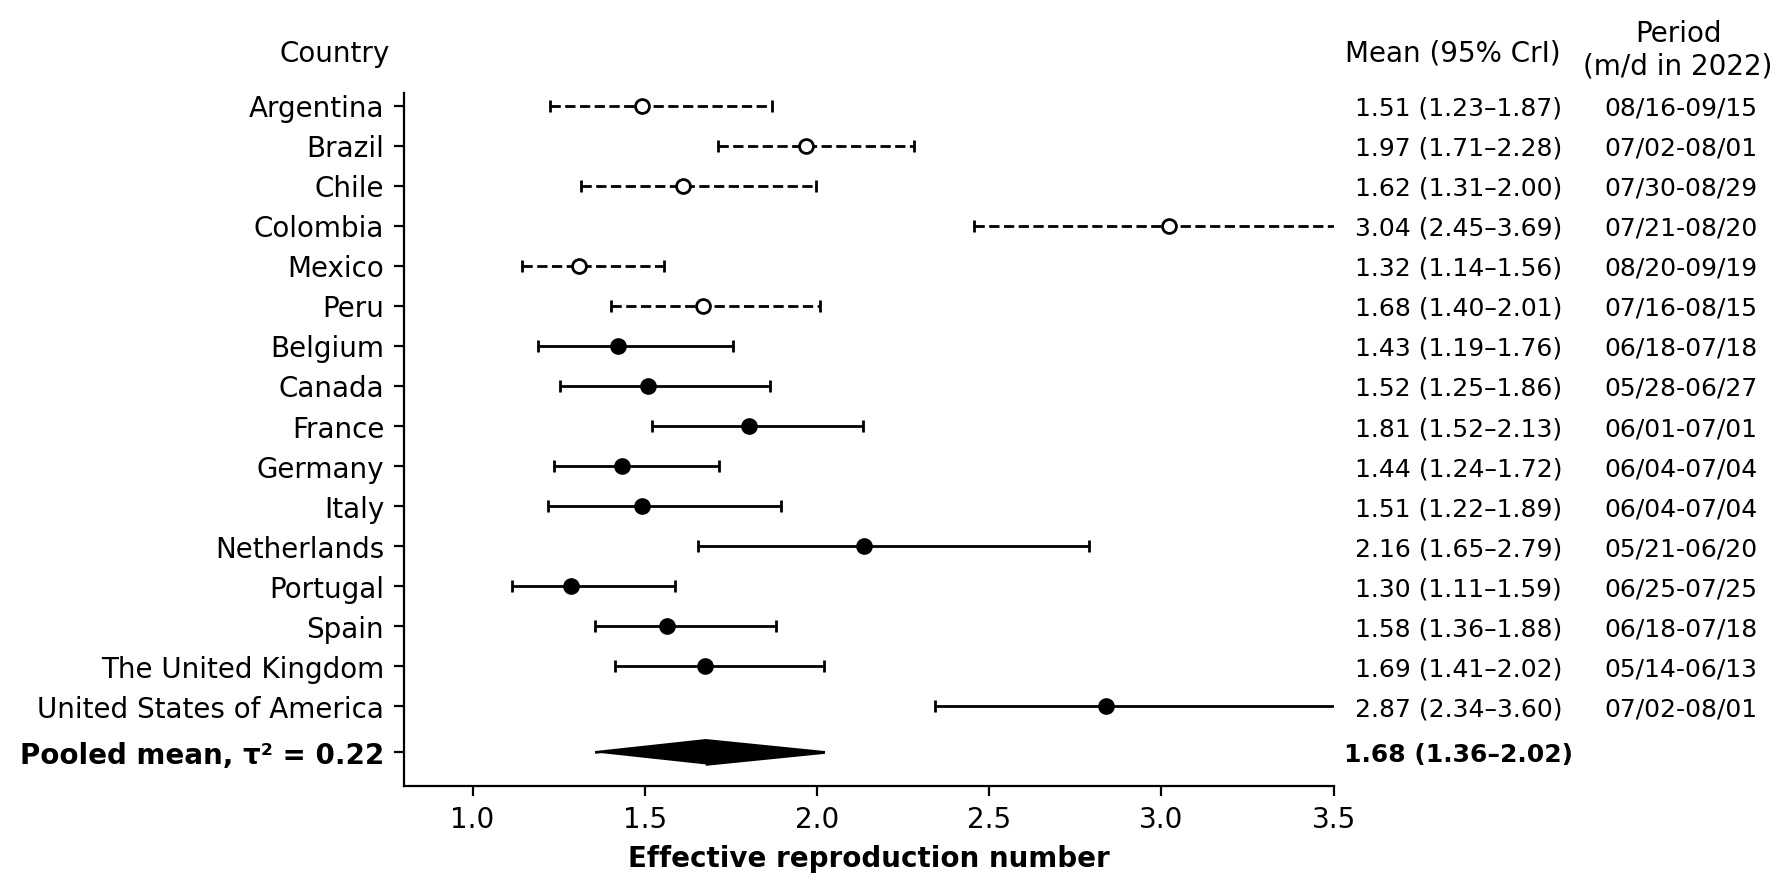

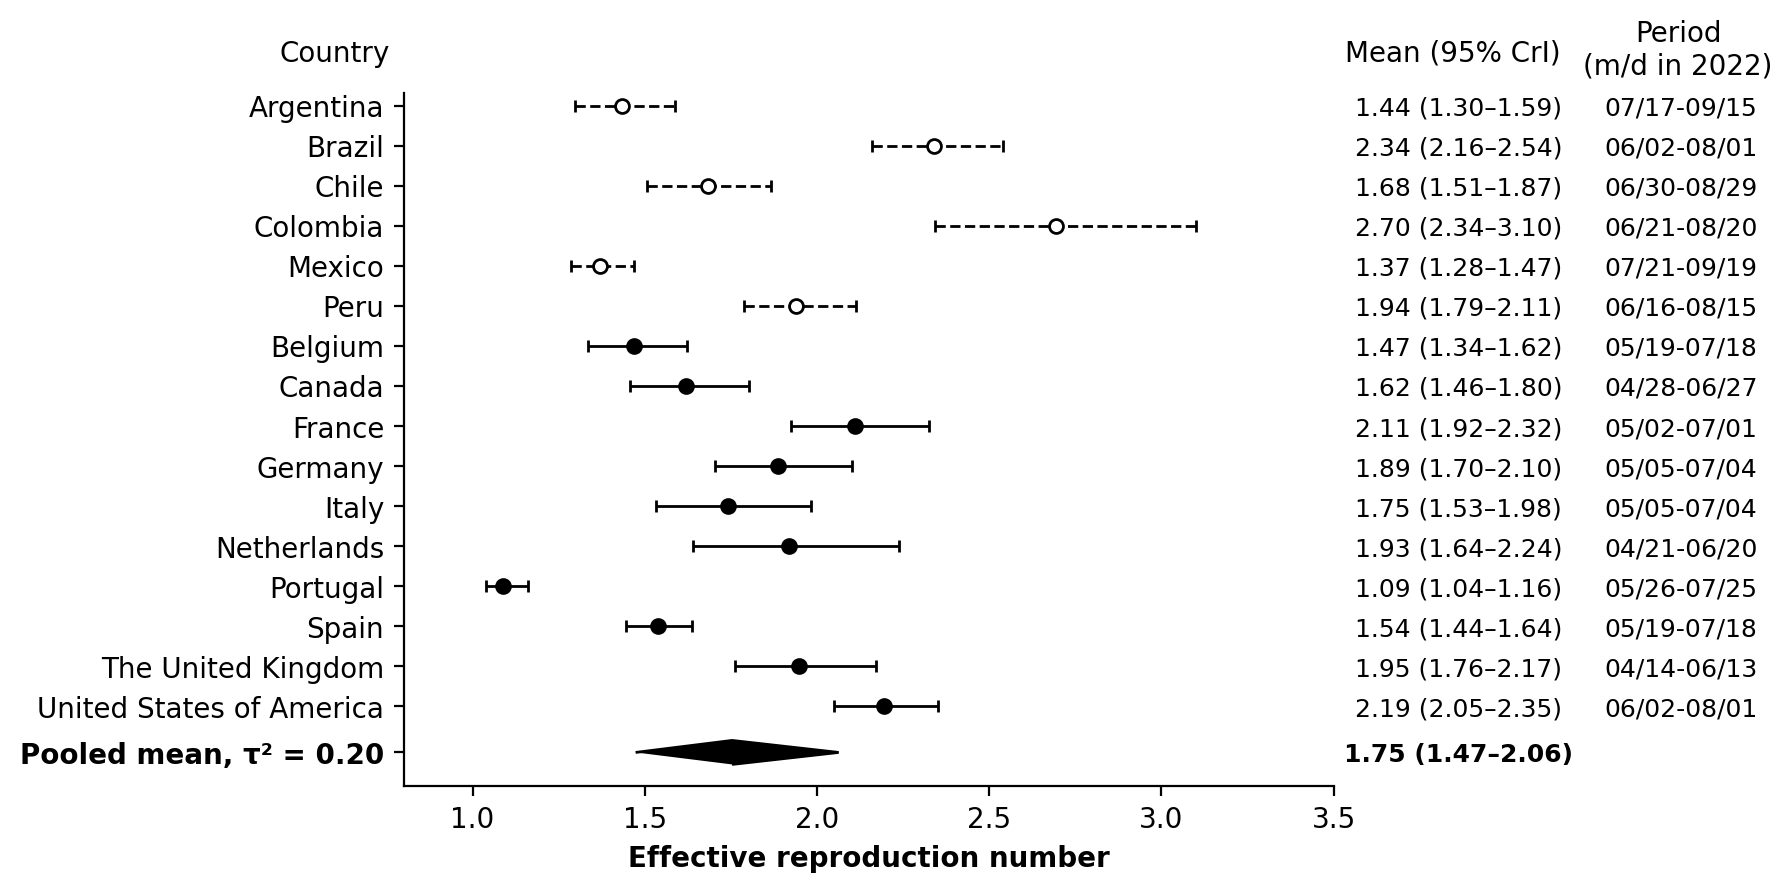

In [281]:
# for presentation


for Tupper_ in [30, 60]:
    fig = plt.figure(figsize = [6, 4.5])  #, dpi = 300
    ax1 = fig.add_subplot()
    
    df_ = df_stats_countries.copy().merge(df_cumcases_selection.loc[:, ['country', 'cases', 'peak_cases', 'peak_date']])\
        .loc[lambda d: (d['var']=='R0')&(d['expwindow']==Tupper_)][::-1]
    
    df_['color'] = ['lightgrey' if (who_region=='AMRO')&(country!='united states of america')&(country!='canada') else 'k' for country, who_region in zip(df_.country,df_.who_region)]
    df_ = df_.sort_values('color')
    
    df_['Source'] = [x.title().replace(' Of ', ' of ') for x in df_['country']]
    df_['Source_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]
    
    for clr_ in df_['color'].drop_duplicates().values:
        df__ = df_.loc[lambda d: d['color']==clr_]
        lsty = 'dashed' if clr_=='lightgrey' else 'solid'
        eb1 = ax1.errorbar(x=list(df__['median']), y=df__['Source_y'], 
                     xerr=[list(df__['median'] - df__['q2.5']), list(df__['q97.5'] - df__['median'])], color='k', capsize=2,
                     linestyle='None', linewidth=1, markersize=0)
        if clr_=='lightgrey':
            eb1[-1][0].set_linestyle('--')
            clr0_ = 'w'
        else:
            clr0_ = 'k'
        ax1.plot(list(df__['median']), df__['Source_y'], color='k', mfc=clr0_, 
                 linestyle='None', linewidth=1, marker="o", ms=5)
    
    # Pooled mean
    mean_meta = Df_meta_stats.loc[lambda d: d['expwindow']==Tupper_].loc[lambda d: d['var']=='mu', 'mean'].values[0]
    lower_meta = Df_meta_stats.loc[lambda d: d['expwindow']==Tupper_].loc[lambda d: d['var']=='mu', 'q2.5'].values[0]
    upper_meta = Df_meta_stats.loc[lambda d: d['expwindow']==Tupper_].loc[lambda d: d['var']=='mu', 'q97.5'].values[0]
    τsqr_meta = Df_meta_stats.loc[lambda d: d['expwindow']==Tupper_].loc[lambda d: d['var']=='tau_squared', 'mean'].values[0]
    y_ = -0.15/df_.shape[0]
    h_ = 0.3/df_.shape[0]
    from matplotlib.patches import Polygon
    pts = np.array([[lower_meta, y_], [mean_meta,y_+h_], [upper_meta, y_], [mean_meta, y_-h_], [lower_meta, y_]])
    p = Polygon(pts, closed=False, color='k')
    ax1.add_patch(p)
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xlim(left = .8, right=3.5)
    ax1.get_xaxis().tick_bottom()
    ax1.get_yaxis().tick_left()
    
    ax1.set_ylim(-1/df_.shape[0], np.max(df_['Source_y'])+.02)
    ax1.set_xlabel("Effective reproduction number")
    ax1.set_yticks(np.r_[df_['Source_y'], y_])
    ax1.set_yticklabels(np.r_[df_['Source'], [f'Pooled mean, τ² = {τsqr_meta:.2f}']] )
    
    ax2 = ax1.secondary_yaxis("right")
    ax2.set_yticks(ax1.get_yticks())
    ax2.spines['right'].set_visible(False)
    ax2.tick_params(length=0)
    df_['label'] = [f"{mu:.2f} ({mu_lower:.2f}–{mu_upper:.2f})" for mu, mu_lower, mu_upper in zip(df_['mean'], df_['q2.5'], df_['q97.5'])]
    ax2.set_yticklabels(np.r_[df_['label'], [f'{mean_meta:.2f} ({lower_meta:.2f}–{upper_meta:.2f})']], ha='center', fontsize=9)
    ax2.yaxis.set_tick_params(pad=45)

    ax3 = ax1.secondary_yaxis("right")
    ax3.set_yticks(ax1.get_yticks())
    ax3.spines['right'].set_visible(False)
    ax3.tick_params(length=0)
    df_['label2'] = [f"{(peak_date-pd.DateOffset(days=Tupper_)).strftime('%m/%d')}-{peak_date.strftime('%m/%d')}" for peak_date in df_['peak_date']]
    ax3.set_yticklabels(np.r_[df_['label2'], ['']], ha='center', fontsize=9)
    ax3.yaxis.set_tick_params(pad=125)
    
    [label.set_fontweight('bold') if 'Pool' in label.get_text() else None for label in ax1.get_yticklabels()]
    [label2.set_fontweight('bold') if 'Pool' in label.get_text() else None for label, label2 in zip(ax1.get_yticklabels(),ax2.get_yticklabels())]
    
    [label.set_color('k') if 'Pool' in label.get_text() else None for label in ax1.get_yticklabels()]
    [label2.set_color('k') if 'Pool' in label.get_text() else None for label, label2 in zip(ax1.get_yticklabels(),ax2.get_yticklabels())]
    
    [label.set_color(clr_chn_) if 'China' in label.get_text() else None for label in ax1.get_yticklabels()]
    [label2.set_color(clr_chn_) if 'China' in label.get_text() else None for label, label2 in zip(ax1.get_yticklabels(),ax2.get_yticklabels())]
    
    plt.text(.44, 1.07, 'Country', horizontalalignment='left', fontsize=10)
    plt.text(4.16, 1.07, 'Mean (95% CrI)', horizontalalignment='right', fontsize=10)
    plt.text(4.5, 1.05, 'Period\n(m/d in 2022)', horizontalalignment='center', fontsize=10)
    
    plt.rcParams["axes.labelweight"] = "bold"
    if save_figures:
        plt.savefig(f"../../figures/fig-R0_meta_Tupper-{Tupper_}.pdf", format="pdf", bbox_inches="tight")
    
    plt.show()

## <font color="orange">3b. Selected national outbreaks of 2022: only symptomatic cases</font>

In [28]:
stan_code_exp_growth_global_only_symptomatic = """functions {
    real gengamma_cdf(real x, real q, real mu, real sigma) {
        real logx = log(x),
            z = (logx - mu) / sigma,
            a = inv_square(q),
            value = gamma_cdf(a * exp(q * z) | a, 1);

        return value;
    }

    /* discretized version */
    vector dgengamma(real q, real mu, real sigma, int D) {
        vector[D] res;
        for (k in 1:D)
            res[k] = gengamma_cdf(k - 0.5 | q, mu, sigma);

        if (D > 1)
            return append_row(append_row(res[1], tail(res, D-1) - head(res, D-1)), 1.0 - res[D]);
        else 
            return to_vector({res[1], 1 - res[1]});
    }

    vector dgamma(real param1, real param2, int K) {
        vector[K] res;
        for (k in 1:K)
            res[k] = gamma_cdf(k - 0.5 | param1, param2);

        return append_row(res[1], tail(res, K-1) - head(res, K-1));
    }
}

data {
    int<lower = 1> Tupper; // the cutoffday for the estimation of the exponential growth 
    array[Tupper] int<lower = 0> cases_onset; // number of cases by date of symptom onset starting to be recorded till the day Tupper
    
    // generation time (scale and shape of the Gamma distribution estimated in Guzetta et al. 2022)
    real<lower = 0> genalpha, geninvbeta;
}

transformed data {
    // generation time
    real genmean = genalpha * geninvbeta,
        gensigma = sqrt(genalpha) * geninvbeta;
        
    real jitter = 1e-9;
}

parameters {
    // exponential growth rate
    real logr;
    // initial incidence
    real<lower = 0> i0;
    // process error
    real<lower = 0> phi;
}

transformed parameters {
    real r = exp(logr);
}

model {
    logr ~ std_normal();
    i0 ~ normal(5, 10);
    phi ~ gamma(1, 1);

    for (t in 1:Tupper)
        if (cases_onset[t] > 0)
            target += neg_binomial_2_lupmf(cases_onset[t] | i0 * exp(r * t) + jitter, phi); 
}

generated quantities {
    // basic reproduction number
    real R0 = exp(r * genmean - 0.5 * square(r) * square(gensigma));

    // doubling time
    real doubling_time = log(2) / r; 
}"""

In [29]:
fls = !ls ../../data/WHO | grep ^epicurve_
fls

['epicurve_andorra.csv',
 'epicurve_argentina.csv',
 'epicurve_aruba.csv',
 'epicurve_australia.csv',
 'epicurve_austria.csv',
 'epicurve_bahamas.csv',
 'epicurve_barbados.csv',
 'epicurve_belgium.csv',
 'epicurve_benin.csv',
 'epicurve_bermuda.csv',
 'epicurve_bosnia and herzegovina.csv',
 'epicurve_brazil.csv',
 'epicurve_bulgaria.csv',
 'epicurve_cameroon.csv',
 'epicurve_canada.csv',
 'epicurve_central african republic.csv',
 'epicurve_chile.csv',
 'epicurve_china.csv',
 'epicurve_colombia.csv',
 'epicurve_congo.csv',
 'epicurve_costa rica.csv',
 'epicurve_croatia.csv',
 'epicurve_cuba.csv',
 'epicurve_curaçao.csv',
 'epicurve_cyprus.csv',
 'epicurve_czechia.csv',
 'epicurve_democratic republic of the congo.csv',
 'epicurve_denmark.csv',
 'epicurve_dominican republic.csv',
 'epicurve_ecuador.csv',
 'epicurve_el salvador.csv',
 'epicurve_estonia.csv',
 'epicurve_finland.csv',
 'epicurve_france.csv',
 'epicurve_georgia.csv',
 'epicurve_germany.csv',
 'epicurve_ghana.csv',
 'epicurve_

In [30]:
%%time
starting_date_global = pd.to_datetime('2022-01-01', format='%Y-%m-%d')
ending_date_global = pd.to_datetime('2022-12-31', format='%Y-%m-%d')

df_cumcases = None
for fl_ in fls:
    df_ = pd.read_csv(os.path.join('../../data/WHO', fl_))
    df_['reference_date'] = pd.to_datetime(df_.reference_date, format='%Y-%m-%d')
    df_ = df_.loc[lambda d: d.reference_date<=ending_date_global]
    country_ = fl_.split('_')[1][:-4]
    who_region_ = df_.who_region.values[0]
    print(country_)
    if len(df_.loc[lambda d: d.date_type=='Onset']) > 0:
        df_mxs_ = df_.loc[lambda d: d.date_type=='Onset']
        df_mxs_ = df_mxs_.loc[lambda d: d.cases==np.max(df_mxs_.cases)]
        df_mxs_ = df_mxs_.loc[lambda d: d.reference_date==np.min(df_mxs_.reference_date)]
        df_cumcases_ = pd.DataFrame({'country': [country_], 'who_region': who_region_, 'cases': [df_['cases'].sum()], 
                                     'peak_cases': df_mxs_.cases, 'peak_date': df_mxs_.reference_date, 'peak_date_type': df_mxs_.date_type, 
                                     'file': fl_})
        df_cumcases = df_cumcases_ if df_cumcases is None else pd.concat([df_cumcases, df_cumcases_], ignore_index=True)
df_cumcases

andorra
argentina
aruba
australia
austria
bahamas
barbados
belgium
benin
bermuda
bosnia and herzegovina
brazil
bulgaria
cameroon
canada
central african republic
chile
china
colombia
congo
costa rica
croatia
cuba
curaçao
cyprus
czechia
democratic republic of the congo
denmark
dominican republic
ecuador
el salvador
estonia
finland
france
georgia
germany
ghana
greece
guam
guatemala
guyana
honduras
hungary
iceland
india
indonesia
ireland
israel
italy
jamaica
japan
latvia
lebanon
liberia
lithuania
luxembourg
malta
mexico
morocco
netherlands
new caledonia
new zealand
nigeria
norway
panama
peru
philippines
poland
portugal
qatar
republic of korea
republic of moldova
romania
saint martin
san marino
saudi arabia
serbia
singapore
slovakia
slovenia
south africa
spain
sri lanka
sudan
sweden
switzerland
thailand
the united kingdom
türkiye
ukraine
united arab emirates
united states of america
uruguay
venezuela (bolivarian republic of)
viet nam
CPU times: user 362 ms, sys: 7.26 ms, total: 369 ms
Wall 

,country,who_region,cases,peak_cases,peak_date,peak_date_type,file
0,andorra,EURO,4,1,2022-06-20,Onset,epicurve_andorra.csv
1,argentina,AMRO,1037,18,2022-09-15,Onset,epicurve_argentina.csv
2,aruba,AMRO,3,2,2022-08-09,Onset,epicurve_aruba.csv
3,australia,WPRO,40,2,2022-05-08,Onset,epicurve_australia.csv
4,austria,EURO,327,8,2022-07-21,Onset,epicurve_austria.csv
...,...,...,...,...,...,...,...
86,united arab emirates,EMRO,16,3,2022-05-19,Onset,epicurve_united arab emirates.csv
87,united states of america,AMRO,29000,530,2022-08-01,Onset,epicurve_united states of america.csv
88,uruguay,AMRO,11,1,2022-07-20,Onset,epicurve_uruguay.csv
89,venezuela (bolivarian republic of),AMRO,12,2,2022-09-13,Onset,epicurve_venezuela (bolivarian republic of).csv


In [31]:
# if no selection by symptomatic, then +Ireland 227 cases
df_cumcases_selection = df_cumcases.loc[lambda d: d.cases>700]
print("number of countries: ", len(df_cumcases_selection))
df_cumcases_selection

number of countries:  16


,country,who_region,cases,peak_cases,peak_date,peak_date_type,file
1,argentina,AMRO,1037,18,2022-09-15,Onset,epicurve_argentina.csv
7,belgium,EURO,790,19,2022-07-18,Onset,epicurve_belgium.csv
10,brazil,AMRO,10147,192,2022-08-01,Onset,epicurve_brazil.csv
13,canada,AMRO,1395,29,2022-06-27,Onset,epicurve_canada.csv
14,chile,AMRO,1394,42,2022-08-29,Onset,epicurve_chile.csv
16,colombia,AMRO,4062,78,2022-08-20,Onset,epicurve_colombia.csv
31,france,EURO,4124,64,2022-07-01,Onset,epicurve_france.csv
33,germany,EURO,3676,84,2022-07-04,Onset,epicurve_germany.csv
45,italy,EURO,953,24,2022-07-04,Onset,epicurve_italy.csv
54,mexico,AMRO,3726,58,2022-09-19,Onset,epicurve_mexico.csv


In [35]:
def sim_country_only_sympt(idx, Tupper_):
    df_sel_ = df_cumcases_selection.iloc[idx]
    print(df_sel_)
    
    basename = truncation_date_hk.strftime("%Y%m%d")+f'_Tupper-{Tupper_}_exp_growth_only_sympt_' + df_sel_.country
    standirname = os.path.join(mainstandirname, basename)
    !rm {standirname}/*
    os.makedirs(standirname, exist_ok=True)
    stanscriptdir = '../Dropbox/'+standirname[9:]

    fl_ = df_sel_['file']
    df_ = pd.read_csv(os.path.join('../../data/WHO', fl_))
    df_['reference_date'] = pd.to_datetime(df_.reference_date, format='%Y-%m-%d')
    df_ = df_.loc[lambda d: d.reference_date<=ending_date_global]

    df_country_ = df_.groupby(['date_type', 'reference_date'])['cases'].sum().reset_index().pivot_table(values='cases', columns='date_type', index='reference_date')
    df_country_ = pd.DataFrame(df_country_.to_records()).merge(pd.DataFrame({'reference_date': pd.date_range(starting_date_global, ending_date_global)}), how='outer').fillna(0)
    df_country_ = df_country_.sort_values('reference_date').set_index('reference_date').astype('int64')
    df_country_['reference_day'] = (df_country_.index - starting_date_global).days
    df_ = df_country_

    T_ = df_.shape[0]
    cases_onset_ = df_.loc[lambda d: (d.index>df_sel_.peak_date-pd.DateOffset(days=Tupper_))].Onset.values[:Tupper_]
    cases_reported_ = df_['Reported'].astype('int64').values if 'Reported' in df_.columns else [0]*T_
    cases_diagnosis_ = df_['Diagnosis'].astype('int64').values if 'Diagnosis' in df_.columns else [0]*T_

    stan_data = dict({
        'Tupper': Tupper_,
        'cases_onset': cases_onset_,
        'genalpha': 4.85,
        'geninvbeta': 2.57
    })
    stan_data_file = os.path.join(standirname, 'Data.json')
    cmdstan.write_stan_json(stan_data_file, stan_data)

    stan_inits = dict({
        'r': 0.1,
        'phi': 1.0
    })
    stan_init_file = os.path.join(standirname, 'Inits.json')
    cmdstan.write_stan_json(stan_init_file, stan_inits)

    stan_code_file = os.path.join(standirname, f'fit_exp_growth.stan')
    with open(stan_code_file, "w+") as f:
        f.write(stan_code_exp_growth_global_only_symptomatic)
        f.close()
    
    model = cmdstan.CmdStanModel(stan_file=stan_code_file, cpp_options={'STAN_THREADS': 'TRUE'}, compile='force')
    fit = model.sample(data=stan_data_file, seed = 1, iter_warmup=num_warmup, iter_sampling=1, inits=stan_init_file, parallel_chains=10,
                       show_console=False, show_progress=False, chains = 4000)
    fit.save_csvfiles(dir=standirname)

    idata = az.from_cmdstanpy(posterior=fit)
    df_stats = get_stats(idata.posterior, ['r', 'i0', 'phi', 'R0', 'doubling_time']) 
    df_stats['country'] = df_sel_.country
    df_stats['who_region'] = df_sel_.who_region
    df_stats['expwindow'] = Tupper_

    return(df_stats)

In [ ]:
%%time 
df_stats_countries = None
for Tupper_ in [45, 30, 60]:
    for idx in range(len(df_cumcases_selection)):
        df_stats_ = sim_country_only_sympt(idx, Tupper_)
        df_stats_countries = df_stats_ if df_stats_countries is None else pd.concat([df_stats_countries, df_stats_], ignore_index=True)
df_stats_countries

In [37]:
df_stats_countries['SD'] = [(upper - lower) / 1.96 / 2 for lower, upper in zip(df_stats_countries['q2.5'], df_stats_countries['q97.5'])]
df_stats_countries

,var,time,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat,country,who_region,expwindow,SD
0,r,NA,0.02373,0.01279,0.01965,0.02708,0.03449,0.01352,0.01986,0.02353,0.02736,0.03533,NaN,NaN,NaN,argentina,AMRO,45,0.005564
1,i0,NA,4.02451,2.82557,3.49772,4.34927,5.31067,2.86016,3.57439,3.99280,4.43533,5.37445,NaN,NaN,NaN,argentina,AMRO,45,0.641401
2,phi,NA,6.61832,3.41078,4.79159,7.18866,10.48350,3.66310,5.25063,6.38374,7.69078,10.99858,NaN,NaN,NaN,argentina,AMRO,45,1.871296
3,R0,NA,1.33422,1.16979,1.26241,1.37764,1.50811,1.18013,1.27276,1.32907,1.38963,1.52259,NaN,NaN,NaN,argentina,AMRO,45,0.087362
4,doubling_time,NA,31.04519,17.79070,22.84820,31.78500,47.05620,19.61745,25.33442,29.45195,34.90788,51.25706,NaN,NaN,NaN,argentina,AMRO,45,8.071329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,r,NA,0.06913,0.06246,0.06713,0.07159,0.07573,0.06263,0.06683,0.06915,0.07133,0.07601,NaN,NaN,NaN,united states of america,AMRO,60,0.003413
236,i0,NA,11.92918,9.25274,10.81260,12.66520,14.93500,9.34149,10.94265,11.81135,12.82338,15.06384,NaN,NaN,NaN,united states of america,AMRO,60,1.459783
237,phi,NA,6.82269,4.27375,5.63016,7.39638,9.50676,4.43084,5.85482,6.71739,7.66989,9.80190,NaN,NaN,NaN,united states of america,AMRO,60,1.370168
238,R0,NA,2.19368,2.04643,2.14361,2.24378,2.34457,2.04994,2.14143,2.19324,2.24261,2.35104,NaN,NaN,NaN,united states of america,AMRO,60,0.076811


In [39]:
stan_code_meta_summary = """data {
  int<lower=1> J;  // number of studies with available data
  vector[J] mu_known;  // means of known studies
  vector<lower=0>[J] stderr_known;  // standard errors of known studies
}

parameters {
  real<lower=0> mu, tau_squared;
}

model {
  // Priors
  mu ~ normal(4, 8);  // weakly informative prior for the overall mean
  tau_squared ~ cauchy(0, 5);  // weakly informative prior for the between-study variability

  // Likelihood
  mu_known ~ normal(mu, sqrt(square(stderr_known) + tau_squared));
}

generated quantities {
  real mu_pred;

    {
        // Predict a future observation for a hypothetical new study
        mu_pred = normal_rng(mu, sqrt(tau_squared));
    }
}"""

Df_meta_stats = None
for Tupper_ in [45, 30, 60]:
    basename = f'R0_meta_only_sympt_Tupper-{Tupper_}'
    standirname = os.path.join(mainstandirname, basename)
    if recalc_everything:
        !rm {standirname}/*
        os.makedirs(standirname, exist_ok=True)
        stanscriptdir = '../Dropbox/'+standirname[9:]
            
        stan_code_file = os.path.join(standirname, 'fit_R0_meta.stan')
        with open(stan_code_file, "w+") as f:
            f.write(stan_code_meta_summary)
            f.close()
    
        df_ = df_stats_countries.copy().loc[lambda d: (d['var']=='R0')&(d['expwindow']==Tupper_)][::-1]
        df_ = df_.loc[lambda d: ~((d.who_region=='AMRO')&(d.country!='united states of america')&(d.country!='canada'))]
        
        stan_data = dict({
            'J': df_.shape[0],
            'mu_known': df_['mean'].values,
            'stderr_known': df_['SD'].values
        })
        stan_data_file = os.path.join(standirname, 'Data.json')
        cmdstan.write_stan_json(stan_data_file, stan_data)
        
        def bash_file(stanscriptdir):
            return f"""#!/bin/bash
cwd=$(pwd)
cd {standistribdir_}
make -j4 {stanscriptdir}/fit_R0_meta
cd {stanscriptdir}
mkdir -p diagnostics
for i in {{1..4}}
do
    echo Running ${{i}}
    SEEDNUMBER=$((1+$i))
    ./fit_R0_meta \\
        method=sample num_samples={num_iterations} num_warmup={num_warmup} thin=1 save_warmup=0 adapt delta=0.98 \\
            algorithm=hmc \\
                engine=nuts \\
        random seed=${{SEEDNUMBER}} \\
        id=$i \\
        data file=Data.json \\
        output file=trace-$i.csv \\
            diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
done
echo Finished haha!
"""            
        model = cmdstan.CmdStanModel(stan_file=stan_code_file)
        fit = model.sample(data=stan_data_file, seed = 1, iter_warmup=num_warmup, iter_sampling=1000,
                           show_console=False, show_progress=True, chains = 4)
        fit.save_csvfiles(dir=standirname)

        idata_meta = az.from_cmdstanpy(posterior=fit)
        df_meta_stats = get_stats(idata_meta.posterior, ['mu', 'tau_squared'])
        df_meta_stats['expwindow'] = Tupper_
        Df_meta_stats = df_meta_stats if Df_meta_stats is None else pd.concat([Df_meta_stats, df_meta_stats], ignore_index = True)
Df_meta_stats

rm: cannot remove '../../../Taiwan_Backup/Monkeypox_2022/R0_meta_only_sympt_Tupper-45/*': No such file or directory


22:34:41 - cmdstanpy - INFO - compiling stan file /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_only_sympt_Tupper-45/fit_R0_meta.stan to exe file /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_only_sympt_Tupper-45/fit_R0_meta
22:35:49 - cmdstanpy - INFO - compiled model executable: /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_only_sympt_Tupper-45/fit_R0_meta
22:35:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:35:49 - cmdstanpy - INFO - CmdStan done processing.
22:35:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_only_sympt_Tupper-45/fit_R0_meta.stan', line 17, column 2 to column 66)
Consider re-running with show_console=True if the above output is unclear!



rm: cannot remove '../../../Taiwan_Backup/Monkeypox_2022/R0_meta_only_sympt_Tupper-30/*': No such file or directory


22:35:49 - cmdstanpy - INFO - compiling stan file /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_only_sympt_Tupper-30/fit_R0_meta.stan to exe file /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_only_sympt_Tupper-30/fit_R0_meta
22:36:58 - cmdstanpy - INFO - compiled model executable: /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_only_sympt_Tupper-30/fit_R0_meta
22:36:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:36:58 - cmdstanpy - INFO - CmdStan done processing.
22:36:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_only_sympt_Tupper-30/fit_R0_meta.stan', line 17, column 2 to column 66)
Consider re-running with show_console=True if the above output is unclear!



rm: cannot remove '../../../Taiwan_Backup/Monkeypox_2022/R0_meta_only_sympt_Tupper-60/*': No such file or directory


22:36:59 - cmdstanpy - INFO - compiling stan file /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_only_sympt_Tupper-60/fit_R0_meta.stan to exe file /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_only_sympt_Tupper-60/fit_R0_meta
22:38:08 - cmdstanpy - INFO - compiled model executable: /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_only_sympt_Tupper-60/fit_R0_meta
22:38:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:38:08 - cmdstanpy - INFO - CmdStan done processing.
22:38:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_only_sympt_Tupper-60/fit_R0_meta.stan', line 17, column 2 to column 66)
Consider re-running with show_console=True if the above output is unclear!


,var,time,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat,expwindow
0,mu,NA,1.66011,1.40631,1.58180,1.74538,1.92978,1.40709,1.57640,1.65638,1.74128,1.92985,1869.95315,1551.64982,1.00161,45
1,tau_squared,NA,0.15359,0.02815,0.06365,0.14174,0.35993,0.04260,0.08245,0.11977,0.18316,0.46299,1966.73510,2158.49753,1.00156,45
2,mu,NA,1.67698,1.35029,1.56985,1.75651,2.01360,1.35564,1.57985,1.66956,1.76971,2.02295,1481.45621,1357.71411,1.00218,30
3,tau_squared,NA,0.22413,0.00099,0.03590,0.18344,0.62173,0.02271,0.09269,0.16656,0.27498,0.78030,1479.60047,1201.50803,1.00020,30
4,mu,NA,1.75328,1.47006,1.66032,1.83845,2.05488,1.47328,1.66460,1.75170,1.84356,2.06286,1801.24776,1421.47625,1.00113,60
5,tau_squared,NA,0.20376,0.04231,0.07855,0.17452,0.49900,0.06021,0.11178,0.15715,0.23875,0.64037,1820.76092,2011.83821,1.00141,60


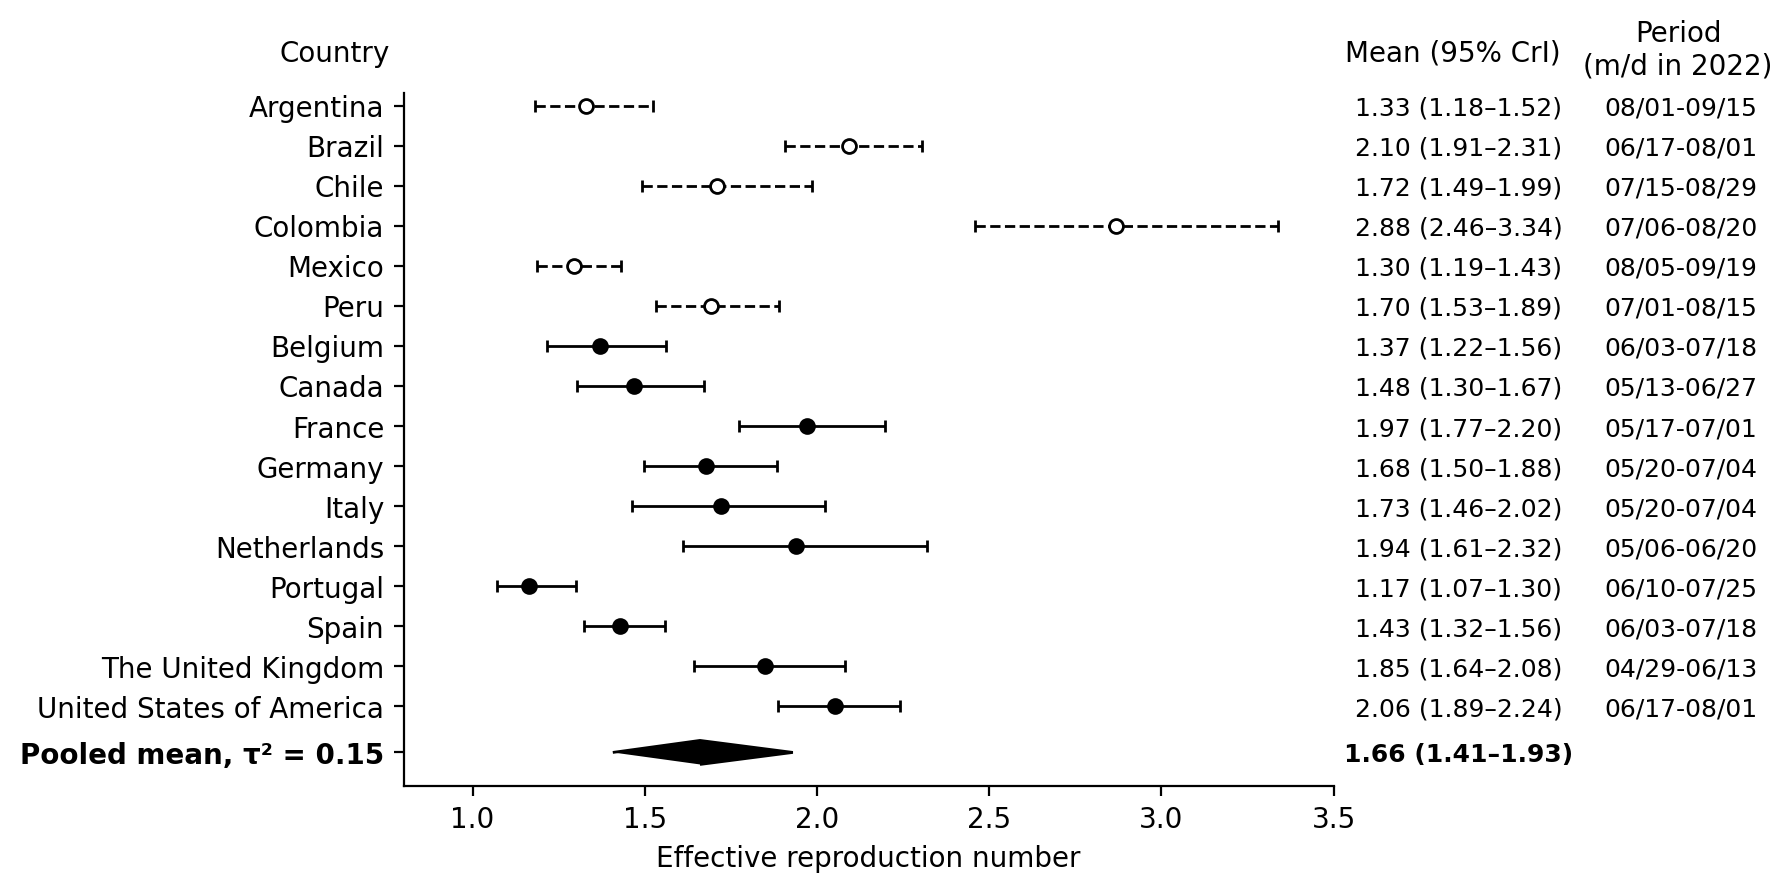

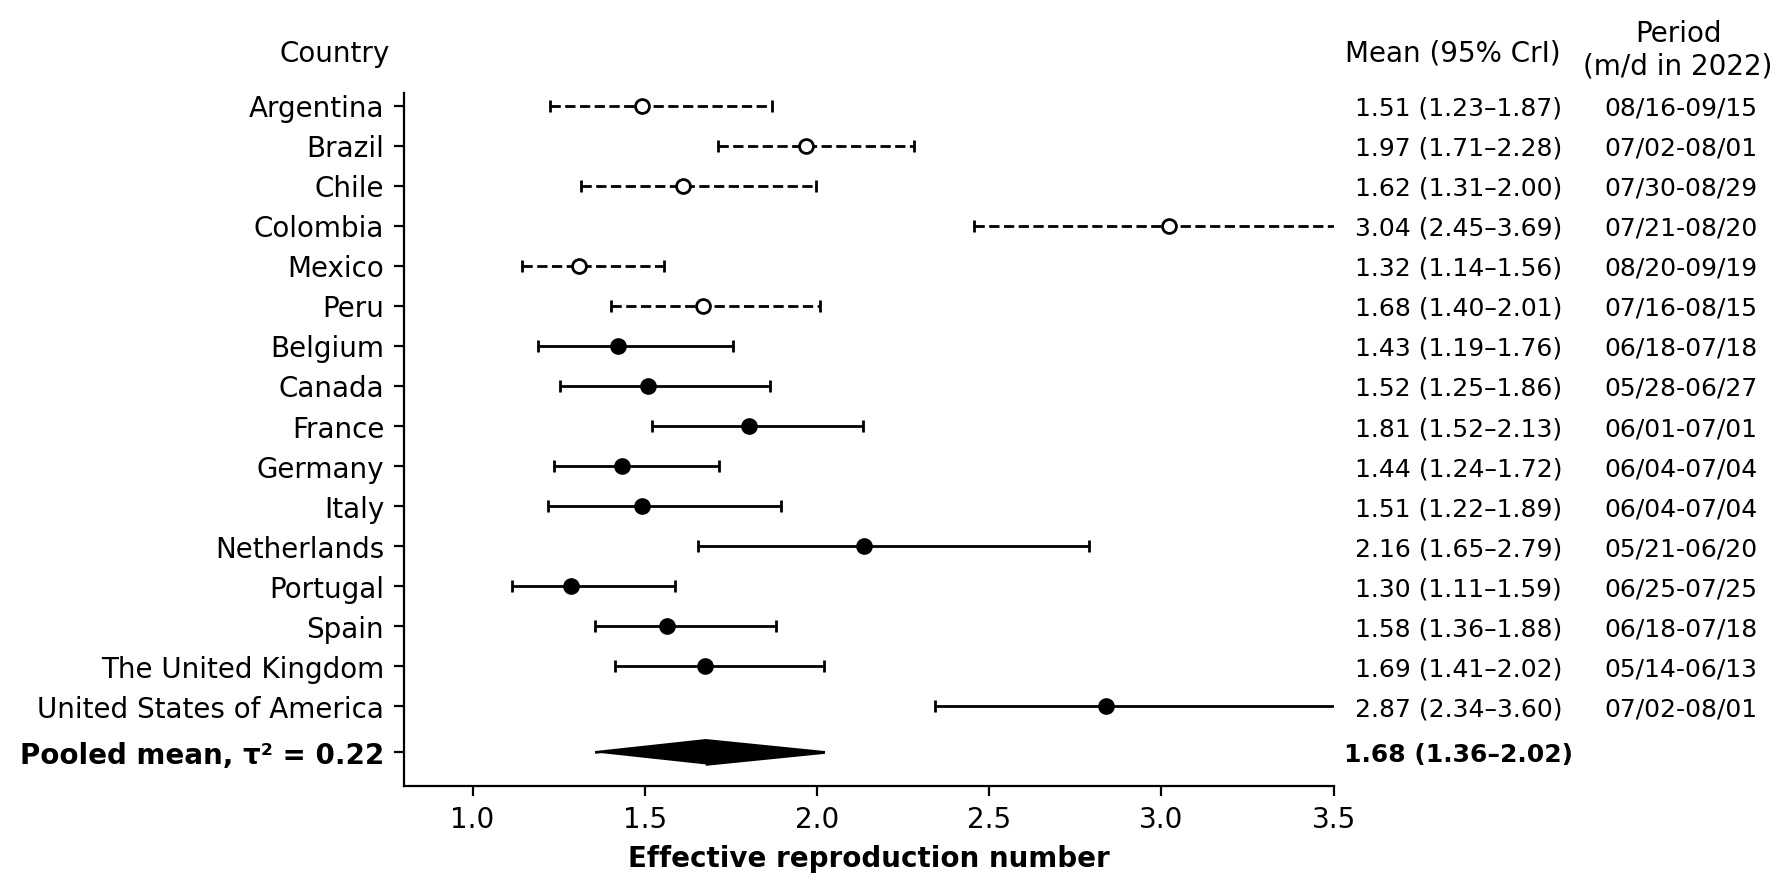

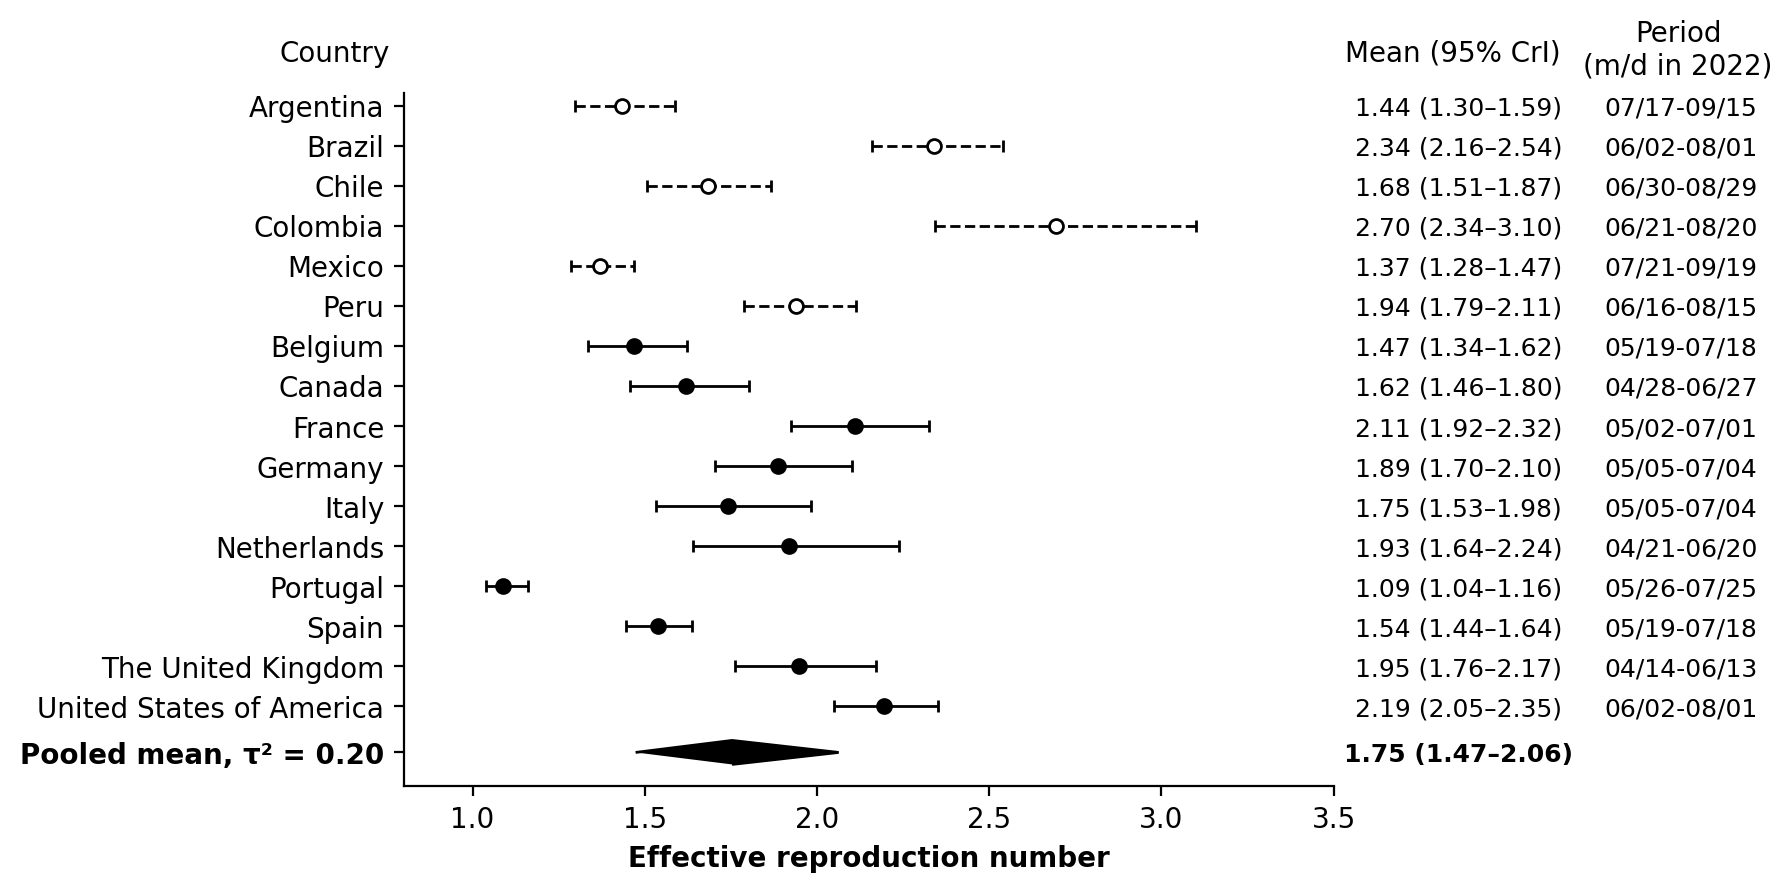

In [40]:
# for presentation
for Tupper_ in [45, 30, 60]:
    fig = plt.figure(figsize = [6, 4.5])  #, dpi = 300
    ax1 = fig.add_subplot()
    
    df_ = df_stats_countries.copy().merge(df_cumcases_selection.loc[:, ['country', 'cases', 'peak_cases', 'peak_date']])\
        .loc[lambda d: (d['var']=='R0')&(d['expwindow']==Tupper_)][::-1]
    
    df_['color'] = ['lightgrey' if (who_region=='AMRO')&(country!='united states of america')&(country!='canada') else 'k' for country, who_region in zip(df_.country,df_.who_region)]
    df_ = df_.sort_values('color')
    
    df_['Source'] = [x.title().replace(' Of ', ' of ') for x in df_['country']]
    df_['Source_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]
    
    for clr_ in df_['color'].drop_duplicates().values:
        df__ = df_.loc[lambda d: d['color']==clr_]
        lsty = 'dashed' if clr_=='lightgrey' else 'solid'
        eb1 = ax1.errorbar(x=list(df__['median']), y=df__['Source_y'], 
                     xerr=[list(df__['median'] - df__['q2.5']), list(df__['q97.5'] - df__['median'])], color='k', capsize=2,
                     linestyle='None', linewidth=1, markersize=0)
        if clr_=='lightgrey':
            eb1[-1][0].set_linestyle('--')
            clr0_ = 'w'
        else:
            clr0_ = 'k'
        ax1.plot(list(df__['median']), df__['Source_y'], color='k', mfc=clr0_, 
                 linestyle='None', linewidth=1, marker="o", ms=5)
    
    # Pooled mean
    mean_meta = Df_meta_stats.loc[lambda d: d['expwindow']==Tupper_].loc[lambda d: d['var']=='mu', 'mean'].values[0]
    lower_meta = Df_meta_stats.loc[lambda d: d['expwindow']==Tupper_].loc[lambda d: d['var']=='mu', 'q2.5'].values[0]
    upper_meta = Df_meta_stats.loc[lambda d: d['expwindow']==Tupper_].loc[lambda d: d['var']=='mu', 'q97.5'].values[0]
    τsqr_meta = Df_meta_stats.loc[lambda d: d['expwindow']==Tupper_].loc[lambda d: d['var']=='tau_squared', 'mean'].values[0]
    y_ = -0.15/df_.shape[0]
    h_ = 0.3/df_.shape[0]
    from matplotlib.patches import Polygon
    pts = np.array([[lower_meta, y_], [mean_meta,y_+h_], [upper_meta, y_], [mean_meta, y_-h_], [lower_meta, y_]])
    p = Polygon(pts, closed=False, color='k')
    ax1.add_patch(p)
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xlim(left = .8, right=3.5)
    ax1.get_xaxis().tick_bottom()
    ax1.get_yaxis().tick_left()
    
    ax1.set_ylim(-1/df_.shape[0], np.max(df_['Source_y'])+.02)
    ax1.set_xlabel("Effective reproduction number")
    ax1.set_yticks(np.r_[df_['Source_y'], y_])
    ax1.set_yticklabels(np.r_[df_['Source'], [f'Pooled mean, τ² = {τsqr_meta:.2f}']] )
    
    ax2 = ax1.secondary_yaxis("right")
    ax2.set_yticks(ax1.get_yticks())
    ax2.spines['right'].set_visible(False)
    ax2.tick_params(length=0)
    df_['label'] = [f"{mu:.2f} ({mu_lower:.2f}–{mu_upper:.2f})" for mu, mu_lower, mu_upper in zip(df_['mean'], df_['q2.5'], df_['q97.5'])]
    ax2.set_yticklabels(np.r_[df_['label'], [f'{mean_meta:.2f} ({lower_meta:.2f}–{upper_meta:.2f})']], ha='center', fontsize=9)
    ax2.yaxis.set_tick_params(pad=45)

    ax3 = ax1.secondary_yaxis("right")
    ax3.set_yticks(ax1.get_yticks())
    ax3.spines['right'].set_visible(False)
    ax3.tick_params(length=0)
    df_['label2'] = [f"{(peak_date-pd.DateOffset(days=Tupper_)).strftime('%m/%d')}-{peak_date.strftime('%m/%d')}" for peak_date in df_['peak_date']]
    ax3.set_yticklabels(np.r_[df_['label2'], ['']], ha='center', fontsize=9)
    ax3.yaxis.set_tick_params(pad=125)
    
    [label.set_fontweight('bold') if 'Pool' in label.get_text() else None for label in ax1.get_yticklabels()]
    [label2.set_fontweight('bold') if 'Pool' in label.get_text() else None for label, label2 in zip(ax1.get_yticklabels(),ax2.get_yticklabels())]
    
    [label.set_color('k') if 'Pool' in label.get_text() else None for label in ax1.get_yticklabels()]
    [label2.set_color('k') if 'Pool' in label.get_text() else None for label, label2 in zip(ax1.get_yticklabels(),ax2.get_yticklabels())]
    
    [label.set_color(clr_chn_) if 'China' in label.get_text() else None for label in ax1.get_yticklabels()]
    [label2.set_color(clr_chn_) if 'China' in label.get_text() else None for label, label2 in zip(ax1.get_yticklabels(),ax2.get_yticklabels())]
    
    plt.text(.44, 1.07, 'Country', horizontalalignment='left', fontsize=10)
    plt.text(4.16, 1.07, 'Mean (95% CrI)', horizontalalignment='right', fontsize=10)
    plt.text(4.5, 1.05, 'Period\n(m/d in 2022)', horizontalalignment='center', fontsize=10)
    
    plt.rcParams["axes.labelweight"] = "bold"
    if save_figures:
        plt.savefig(f"../../figures/fig-R0_meta_only_sympt_Tupper-{Tupper_}.pdf", format="pdf", bbox_inches="tight")
    
    plt.show()